# OPF20 - Centroids

## Defining the Low-Block

We will assess the non-FCN team only to determine if they are in a low-block or not. 

Every 0.5 seconds we will perform a number of calculations to identify if a low-block is being deployed. The calculations will result in number TRUE/FALSE values. If all are TRUE, a low-block is being deployed: 

1. Centroids - ADD EXPLAINATION


2. The mean vertical distance from the goal-line of the lowest two defensive players should be less that 25m. A low block is designed to protect the space in-behind. A defensive line higher than 25m would still allow space in-behind to be exploited by the attacking team

<img src="lbz2.jpg" width = "80%" align="centre">

3. If there are 4 or more defensive players (not including GK) within their own box, at which point the low block has turned into a 'deep block'.

<img src="lbz3.jpg" width = "80%" align="centre">


4. If there are 3 or more defensive team players within their attacking half of the pitch. A 'low block' is then deemed impossible to create

<img src="lbz4.jpg" width = "80%" align="centre">

5. The ball is deemed to be 'Alive' (in-play)


6. There has not been free-kick by the attacking side within the attacking half of the field within the last 3 seconds


7. There has not been corner by the attacking side within the last 10 seconds

## FCN Strategies to Unlock the Low Block

Our Plan when Facing a Low-Block

The core objectives :

Get in behind the defence and into our ‘assist-areas’ - leading to high xG shots
Using combinations and runs 
Maintaining good positions to regain the Ball if we lose it
Have balance in case of losing the ball (Attack with 5-6 players and balance with 4-5)
* If we force them back into a ‘deep block’, we look to take sensible shots from edge of the box or just inside. 

* not a core objective and only as a result of trying to achieve 1-4

Strategies to Break the line: 

1. Forward runs (from multiple players) in behind when no pressure on the Ball

2. Quick switches of play, quick passing to open player in wide areas. 

3. Mini-games in wide areas (4v4, 3v3 - or our overload) - draw them in, slow the tempo and then quick combos to break the line or get into the box. 

4. Receiving the ball in outside pockets for half-space run or pass to inside pocket if half-space run is not on

5. Receiving the ball in central and inside pockets, for runs and combinations (pre-defined). 

# Code

## Setup
Libraries and Data Load

#### Import Libraries

In [1]:
# || 1. Import Libaries
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import operator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import HTML

from parsing_functions import * # -- seperate .py file 
from print_out_functions import * # -- seperate .py file 
from tracab_utils import * # -- seperate .py file 
from event_utils import * # -- seperate .py file 
from speed_functions import * # -- seperate .py file 


# Display options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 3000

# Display options for numpy
np.set_printoptions(linewidth=120, suppress=True)

# Display options for pyplot
%config InlineBackend.figure_format = 'retina'

## Cell computation timer
%load_ext autotime

## other imports 
from pitch import Pitch # -- seperate .py file 

## KDE specific 
import scipy
import scipy.stats as st
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!


#### Import Data

In [2]:
select_your_match = "984564"

# || 2. Declare test data locations
f7_file = r"C:\Users\Home\Documents\OptaPro Forum20012020\Updated Data\Latest\1sthalf\f7/" + select_your_match + ".xml"
f24_file = r"C:\Users\Home\Documents\OptaPro Forum20012020\Updated Data\Latest\1sthalf\f73/" + select_your_match + ".xml"
metadata_file = r"C:\Users\Home\Documents\OptaPro Forum20012020\Updated Data\Latest\1sthalf\Metadata/" + select_your_match + ".xml"
tracab_file = r"C:\Users\Home\Documents\OptaPro Forum20012020\Updated Data\Latest\1sthalf\Tracking/" + select_your_match + ".dat"



# || 3. Summary Header Print Out
#print("-" * 80)
#string_print_to_edge("OPTA F24 and Tracab Syncing Algorithm", 80)

# || 4. Parse test data
#    convert to loaded files for production)
#blank_line_print()
#string_print_to_edge("Parsing data", 80)
events = parse_f24(f24_file)

# [print(f) for f in events.columns]
# exit()
tracking_meta = parse_tracking_metadata(metadata_file)
tracking = parse_tracab(tracab_file, metadata_file)

# || 5. Augment Tracab Data
#blank_line_print()
#string_print_to_edge("Augmenting data", 80)

## trim tracking data
during_game_time = [is_frame_during_game_time(f, tracking_meta) for f in tracking.frameID]
tracking = tracking[during_game_time]

# numerous augmentations to tracking
tracking['period_id'] = [period_id_calc(f, tracking_meta) for f in tracking.frameID]
tracking = add_player_id(f7_file, tracking)
tracking = add_attacking_direction(tracking, tracking_meta)
tracking = add_ball_xy(tracking)
tracking = add_distance_to_ball(tracking)
tracking = add_distance_to_goals(tracking)
tracking = create_opta_coords(tracking, tracking_meta)
tracking = add_team_in_possession(tracking)
tracking = add_speed_classification(tracking)

# augment event data
events = add_all_time_syncs(events, tracking_meta)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Home\\Documents\\OptaPro Forum20012020\\Updated Data\\Latest\\1sthalf\\f73/984564.xml'

time: 320 ms


In [8]:
# check if tracking has loaded
tracking.head(2)

frameID  team  target_id  jersey_no     x   y  z   speed ball_owning_team  \
0  1261225    10        100        999     6  -8  0  163.00                A   
1  1261225     1          1          1 -5229  24  0    0.13                A   

  ball_status ball_contact  period_id    position player_id team_id  \
0       Alive      SetAway          1        ball    000000  000000   
1       Alive           NA          1  Goalkeeper    167040    1943   

        player_name  attacking_direction  ball_x  ball_y  distance_to_ball  \
0              ball                    0       6      -8               0.0   
1  Patrick Carlgren                    1       6      -8            5235.1   

   distance_to_goal1  distance_to_goal2  opta_x  opta_y  team_in_possession  \
0        5256.006088        5244.006102      50      50               False   
1          31.890437       10479.027484       0      50               False   

            speed_class  
0  high_speed_sprinting  
1              standing

In [9]:
# check if tracking has loaded
events.head(2)

id event_id type_id  period_id  min  sec  outcome player_id  \
0  1168882360        1      34         16    0    0        1      None   
1  1296582699        1      34         16    0    0        1      None   

  team_id     x     y sequence_id possession_id    1   10  102  103  107  108  \
0    1943  50.0  50.0        None          None  NaN  NaN  NaN  NaN  NaN  NaN   
1    2592  50.0  50.0        None          None  NaN  NaN  NaN  NaN  NaN  NaN   

   113  121  123  124  127   13  ...    7   72   73   74   75   76   78   79  \
0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

     8   80   81   82   83   84   88   94 competition_id game_id home_team_id  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN            100  984564         1943   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN            100  984564         1943   

  home_team_name away_team_id   away_team_name    competition_name season_id  \
0     Randers FC         2592  FC Nordsjælland  Danish Superligaen      2018   
1     Randers FC         2592  FC Nordsjælland  Danish Superligaen      2018   

  frameID  
0       0  
1       0  

[2 rows x 155 columns]

## Coding the Low Block

### Subsetting the Tracking Data for the Non-FCN team

First we make a subset of the tracking data for just the team that is not FCN

Determine which team id is the opposition to FCN.

The 'team' column in the tracking data has three possible values [1 = home, 0 = away, 10 = ball]

In [10]:
## check first row in event data to determine which team FCN was, assign the result
## to the 'FCN_team' variable

if events.iloc[0]['home_team_id'] == "2592":
    FCN_team = 1
elif events.iloc[0]['away_team_id'] == "2592":
    FCN_team = 0
else:
    print("ERRRRRROOOOOOOR ************** NOT FCN")

oppo_tracking = tracking[tracking['team'] != FCN_team].reset_index(drop=True)
oppo_tracking = oppo_tracking[oppo_tracking['team'] != 10].reset_index(drop=True)



### Make a List of All Frames that 'in-play' and FCN in Possession

In [11]:
## there is a ball_status column within the tracking data with 
## two options ["Alive", "Dead"] - we keep the "Alive" frames only

alive_tracking = oppo_tracking[oppo_tracking['ball_status'] == "Alive"].reset_index(drop=True)

## create a list of the frameIDs that are in-play
all_alive_frames = list(set(alive_tracking['frameID']))

## we will measure every 1/5 second of tracking data to see if 
## there is a low-block during that frame. This reduces the computational
## load of the analysis. The tracking data has 25 frames of data per second
## Let's take every 5th frame of the all_alive_frames
all_alive_frames = all_alive_frames[0::12]

## we then remove all frames where opposition were in possession
frame_options = oppo_tracking[oppo_tracking['frameID'].isin(all_alive_frames)].reset_index(drop=True)[['frameID', 'team_in_possession']]
all_out_possession_frames = frame_options[frame_options['team_in_possession'] == False].reset_index(drop=True).drop_duplicates()['frameID'].reset_index(drop=True)

### Calculate Defensive Centroid

In [12]:
centroid_x = [] # a list to append all the results to
centroid_y = [] # a list to append all the results to


for F in all_out_possession_frames:

    try:

        def_seg = oppo_tracking[oppo_tracking['frameID'] == F].reset_index(drop=True)

        attacking_direction = def_seg.iloc[0]['attacking_direction']

        if attacking_direction == 1:
            centroid_x.append(def_seg.x.mean())
            centroid_y.append(def_seg.y.mean())

        else: 
            centroid_x.append(def_seg.x.mean()*-1)
            centroid_y.append(def_seg.y.mean()*-1)

    except:
        print("FAILEDDDDDDDDD /////////////////////////////////////")


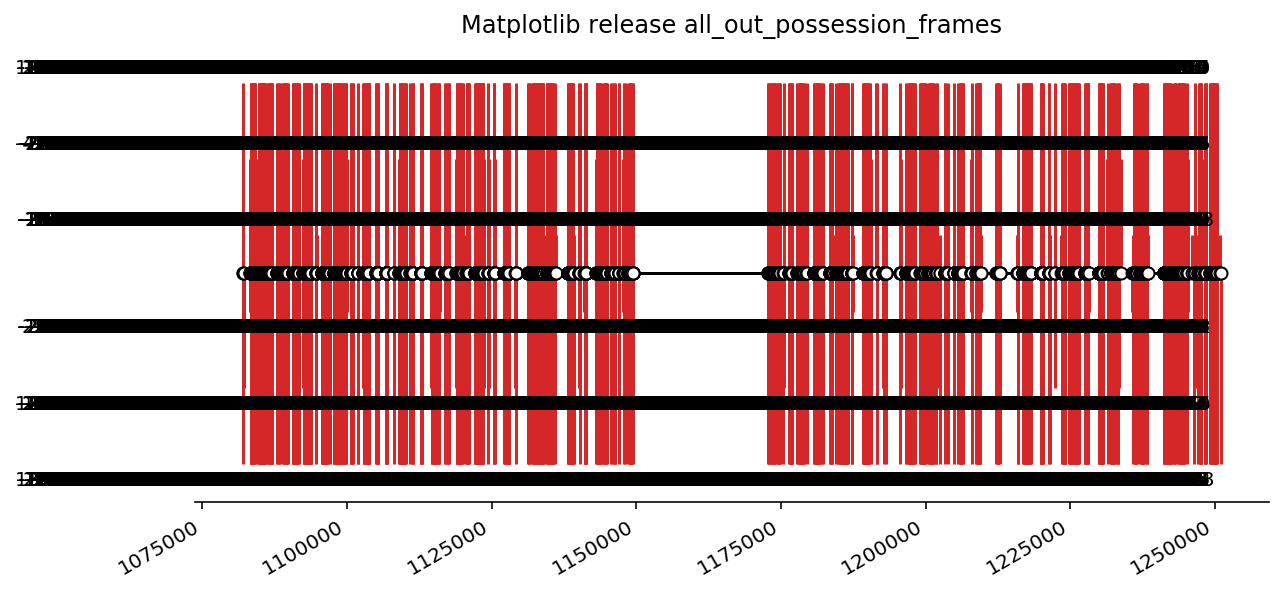

In [11]:
# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(all_out_possession_frames)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(all_out_possession_frames, levels, centroid_x, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# format xaxis with 4 month intervals
#ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
#ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.1)
plt.show()



### New Lists of Centroids within the Zone

Make list of frames that are minium centroid and max centroid

In [20]:
#Low Block Check
xmin = - (tracking_meta['pitch_x'] / 2) * 100
centroid_min = xmin + 1500
centroid_max = xmin + 3000

low_blocks_frameID_centroids = []

for i in range(len(centroid_x)):
    if centroid_x[i] >= centroid_min:
        if centroid_x[i] <= centroid_max:
            low_blocks_frameID_centroids.append(all_out_possession_frames[i])
#low_blocks_frameID_centroids

In [21]:
#Mid Block Check
xmin = - (tracking_meta['pitch_x'] / 2) * 100
centroid_min = xmin + 3000
centroid_max = xmin + 4500

Mid_block_frameID_centroids = []

for i in range(len(centroid_x)):
    if centroid_x[i] >= centroid_min:
        if centroid_x[i] <= centroid_max:
            Mid_block_frameID_centroids.append(all_out_possession_frames[i])
#Mid_block_frameID_centroids

In [23]:
gap_threshold = 100 # under 100 frames = 4 seconds 
duration_threshold = 1 # keep sequences with a length above 200 = (8 seconds)
mid_sequence_id = 0

mid_sequence_id_list = [0]

for lb_frame in range(1,len(Mid_block_frameID_centroids)):
        
        if (Mid_block_frameID_centroids[lb_frame] - Mid_block_frameID_centroids[lb_frame-1]) <= gap_threshold:
            
            mid_sequence_id_list.append(mid_sequence_id)
            
        else:
            mid_sequence_id = mid_sequence_id + 1
            mid_sequence_id_list.append(mid_sequence_id)


mid_sequence_info = pd.DataFrame(
    {'frameID': Mid_block_frameID_centroids,
     'mid_sequence_id': mid_sequence_id_list
    })


start_of_seq = []
end_of_seq = [] 

unique_sequenceids = list(set(mid_sequence_id_list))

for uID in unique_sequenceids:
    
    temp = mid_sequence_info[mid_sequence_info['mid_sequence_id'] == uID]
    
    start_of_seq.append(min(temp.frameID))
    end_of_seq.append(max(temp.frameID))

mid_sequence_summary = pd.DataFrame(
    {'frameID_start': start_of_seq,
     'frameID_end': end_of_seq,
     'mid_sequence_id': unique_sequenceids
    })

## add a duration to thee sequence 
mid_sequence_summary['duration'] = mid_sequence_summary['frameID_end'] - mid_sequence_summary['frameID_start']

mid_sequence_summary = mid_sequence_summary[mid_sequence_summary['duration'] >= duration_threshold].reset_index(drop=True)

mid_sequence_summary

frameID_start  frameID_end  mid_sequence_id  duration
0         1261235      1261439                0       204
1         1262687      1262759                1        72
2         1264810      1264906                3        96
3         1268528      1268576                4        48
4         1269092      1269476                5       384
5         1270772      1270868                6        96
6         1270976      1270988                7        12
7         1272332      1272464                8       132
8         1275104      1275416                9       312
9         1277588      1277600               10        12
10        1277864      1277924               11        60
11        1280244      1280316               12        72
12        1282560      1282584               14        24
13        1284142      1284262               15       120
14        1287422      1287470               16        48
15        1287674      1287782               17       108
16        1289539      1289599               18        60
17        1289936      1290272               19       336
18        1292084      1292204               20       120
19        1302947      1303019               21        72
20        1303463      1303511               22        48
21        1304507      1304543               23        36
22        1305035      1305155               24       120
23        1306538      1306754               25       216
24        1308251      1308719               26       468
25        1309924      1309972               27        48
26        1315355      1315463               28       108
27        1315751      1315847               29        96
28        1321037      1321193               30       156
29        1322369      1322477               31       108
30        1323437      1323845               32       408
31        1325323      1325359               33        36
32        1325479      1325599               34       120
33        1327639      1327735               35        96
34        1328610      1328754               36       144
35        1354804      1355116               37       312
36        1355428      1355572               38       144
37        1356004      1356040               39        36
38        1358174      1358282               41       108
39        1358669      1358705               42        36
40        1358909      1358945               43        36
41        1359053      1359113               44        60
42        1359377      1359425               45        48
43        1361172      1361472               46       300
44        1364228      1364492               47       264
45        1364648      1364912               48       264
46        1366474      1366582               49       108
47        1367358      1367538               50       180
48        1369596      1369680               51        84
49        1374570      1374738               52       168
50        1379464      1379584               54       120
51        1379896      1380760               55       864
52        1381112      1381496               56       384
53        1381683      1382019               57       336
54        1385068      1385188               58       120
55        1388901      1389021               59       120
56        1394934      1394953               60        19
57        1396926      1397045               61       119
58        1406844      1406988               62       144
59        1407171      1407451               63       280
60        1407944      1408323               64       379
61        1409497      1409568               65        71
62        1409975      1410081               66       106
63        1412106      1412351               67       245
64        1412741      1412950               68       209
65        1413867      1414016               69       149
66        1414863      1415278               70       415
67        1416357      1417701               71      1344
68

In [18]:
#High Block Check
xmin = - (tracking_meta['pitch_x'] / 2) * 100
centroid_min = xmin + 4500
centroid_max = xmin + 6000

High_block_frameID_centroids = []

for i in range(len(centroid_x)):
    if centroid_x[i] >= centroid_min:
        if centroid_x[i] <= centroid_max:
            Mid_block_frameID_centroids.append(all_out_possession_frames[i])
#High_block_frameID_centroids

We want to join qualifying low block frames into 'low-'block' sequences, if the next qualifying frame is less than 2 seconds away it is added to the current low-block sequence. A low-block sequence directory can be created with the start and end frames of each distinct low-block sequence. 

In [19]:
gap_threshold = 100 # under 100 frames = 4 seconds 
duration_threshold = 1 # keep sequences with a length above 200 = (8 seconds)
lb_sequence_id = 0

lb_sequence_id_list = [0]

for lb_frame in range(1,len(low_blocks_frameID_centroids)):
        
        if (low_blocks_frameID_centroids[lb_frame] - low_blocks_frameID_centroids[lb_frame-1]) <= gap_threshold:
            
            lb_sequence_id_list.append(lb_sequence_id)
            
        else:
            lb_sequence_id = lb_sequence_id + 1
            lb_sequence_id_list.append(lb_sequence_id)


lb_sequence_info = pd.DataFrame(
    {'frameID': low_blocks_frameID_centroids,
     'lb_sequence_id': lb_sequence_id_list
    })


start_of_seq = []
end_of_seq = [] 

unique_sequenceids = list(set(lb_sequence_id_list))

for uID in unique_sequenceids:
    
    temp = lb_sequence_info[lb_sequence_info['lb_sequence_id'] == uID]
    
    start_of_seq.append(min(temp.frameID))
    end_of_seq.append(max(temp.frameID))

lb_sequence_summary = pd.DataFrame(
    {'frameID_start': start_of_seq,
     'frameID_end': end_of_seq,
     'lb_sequence_id': unique_sequenceids
    })

## add a duration to thee sequence 
lb_sequence_summary['duration'] = lb_sequence_summary['frameID_end'] - lb_sequence_summary['frameID_start']

lb_sequence_summary = lb_sequence_summary[lb_sequence_summary['duration'] >= duration_threshold].reset_index(drop=True)

#lb_sequence_summary


#### Define Animation function 

In [24]:
def animate_shot(starting_frame, ending_frame, FCN_team):

    ##### Animate the Section to Understand 
    from matplotlib import animation
    from pitch import Pitch

    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='tracab',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
                  pitch_width=68,pitch_length=105,stripe=True,goal_type='line',axis=False,label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=6,markerfacecolor='pink',zorder=3)
    team_0, = ax.plot([], [], 'ko', ms=10,markerfacecolor='blue') #red/maroon
    team_1, = ax.plot([], [], 'ko', ms=10,markerfacecolor='red') #purple
    def_centroid, = ax.plot([], [], 'ko', ms=10,markerfacecolor='green') #purple
    att_centroid, = ax.plot([], [], 'ko', ms=10,markerfacecolor='purple') #purple

    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        def_centroid.set_data([], [])
        att_centroid.set_data([], [])


        return ball, team_0, team_1, def_centroid, att_centroid

    # animation function of dataframes' list
    def animate(i):

        frame_ = tracking[tracking['frameID'] == frames_to_animate[i]]
        ball_ = frame_[frame_['team'] == 10].reset_index()
        team0_ = frame_[frame_['team'] != FCN_team].reset_index()
        team0_ = team0_[team0_['team'] != 10].reset_index()
        team1_ = frame_[frame_['team'] == FCN_team].reset_index()

        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.iloc[0]['x'], ball_.iloc[0]['y'])

        # set the player data using the frame id
        team_0.set_data(team0_.x,team0_.y)
        team_1.set_data(team1_.x,team1_.y)
        def_centroid.set_data(team0_.x.mean(),team0_.y.mean())
        att_centroid.set_data(team1_.x.mean(),team1_.y.mean())


        ax.set_title(str(frames_to_animate[i]))
        
        
#         xmin = - (tracking_meta['pitch_x'] / 2) * 100
#         centroid_min = xmin + 1500
#         centroid_max = xmin + 3000



        plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 1500, color = "red")
        plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 3000, color = "red")


        plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) -1500, color = "red")
        plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) - 3000, color = "red")



        return ball, team_0, team_1, def_centroid, att_centroid
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    # anim.save('demo.mp4',dpi=72, fps=6,extra_args=['-vcodec', 'libx264'])
    return(anim)

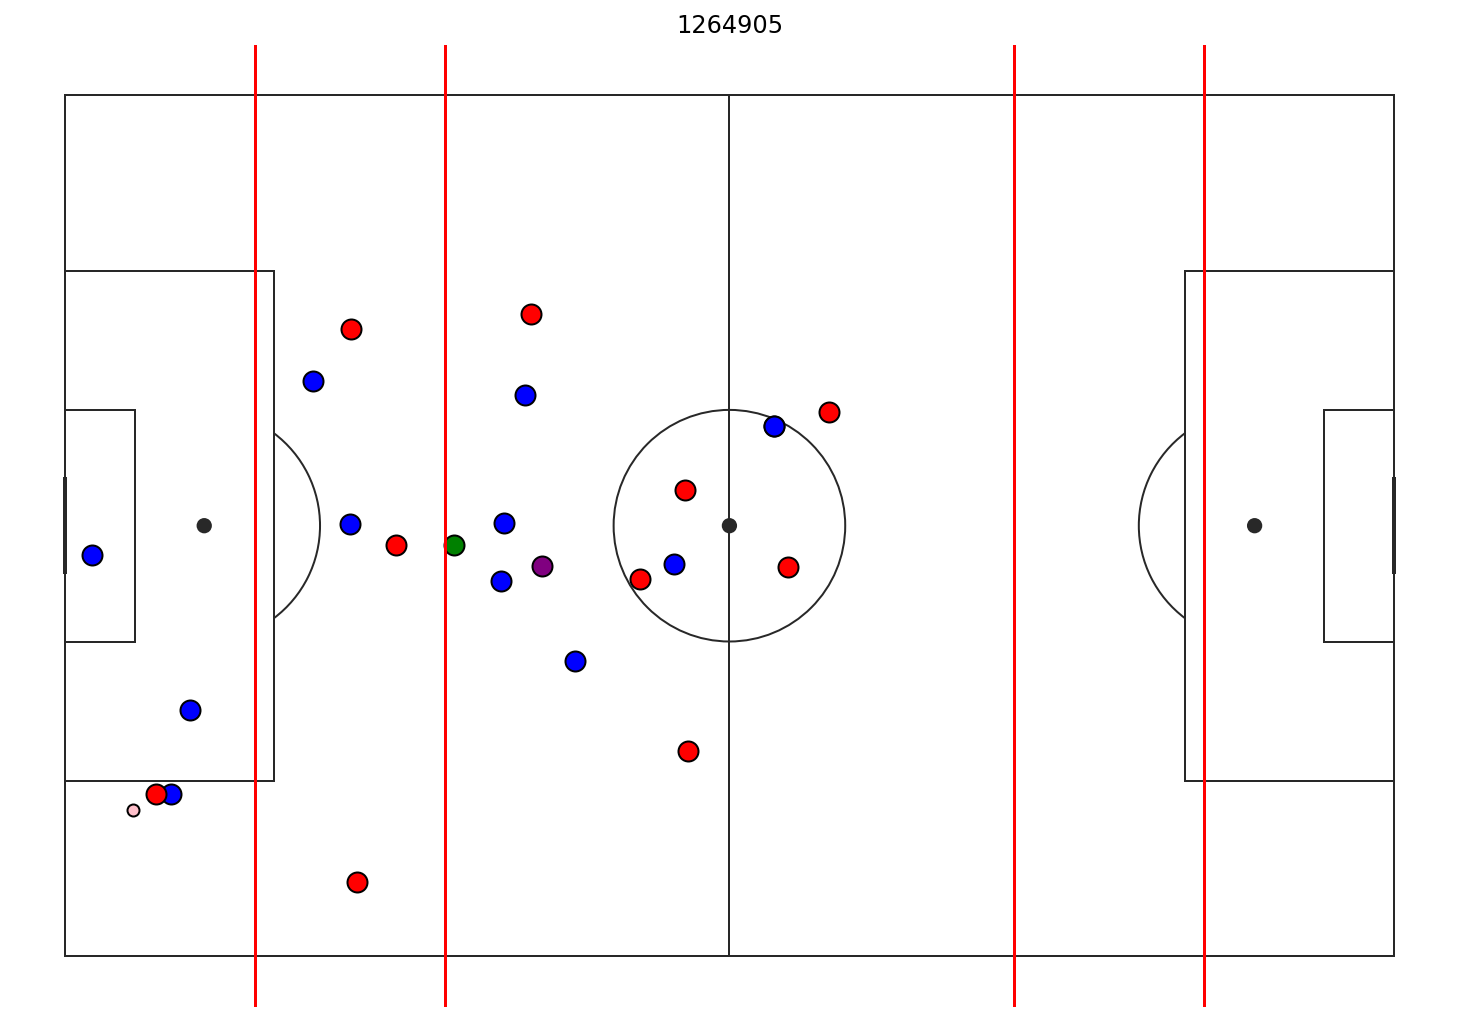

In [26]:
# gap = 25
HTML(animate_shot(1264810,1264906, FCN_team).to_html5_video()) 

Animate a random sequence

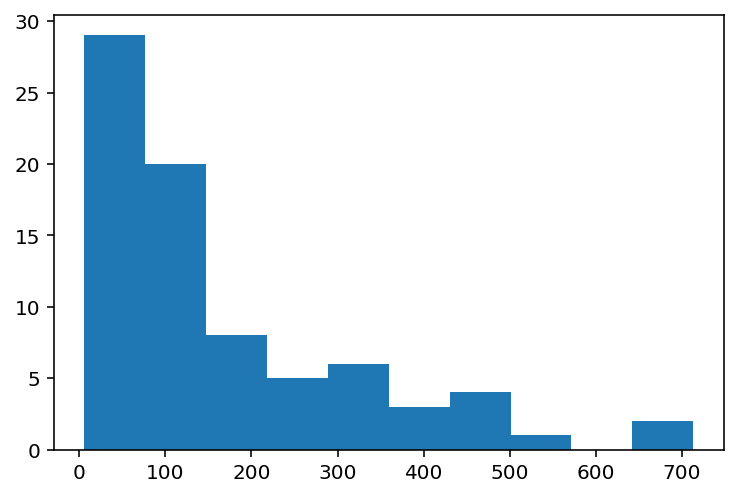

In [42]:
plt.hist(lb_sequence_summary.duration)
lb_sequence_summary = lb_sequence_summary[lb_sequence_summary['duration'] >= 200].reset_index(drop=True)

lb_sequence_summary['lb_sequence_id'] = pd.Series(range(0,len(lb_sequence_summary)))
# pd.Series(range(0,len(lb_sequence_summary)))
# lb_sequence_summary['lb_sequence_id'] = lb_sequence_summary.Index.tolist()


In [ ]:
# import random
# import matplotlib.animation as manimation; manimation.writers.list()

# seq_select = random.choice(list(range(len(lb_sequence_summary))))
# seq_select = 6 # - umcomment to see a exact match sequence based on iloc 

# start_f = lb_sequence_summary.iloc[seq_select]['frameID_start']
# end_f = lb_sequence_summary.iloc[seq_select]['frameID_end']
# print(seq_select)
# HTML(animate_shot(start_f, end_f, FCN_team).to_html5_video())



## Low-Block Broken

In [11]:

lb_seq_list = []
playr_list = []
frame_of_break_list = []
breakID_list = []

for RR in list(range(len(lb_sequence_summary))):

#     RR = 19
    ## select the low block sequence 
    lg_seg_idx = RR
#     print(RR)
    lb_select = lb_sequence_summary.iloc[lg_seg_idx]
#     print("/")
    

    ## create a segment of tracking segment
    lb_seg = tracking[(tracking['frameID'].between(lb_select.frameID_start,lb_select.frameID_end + 75)) & (tracking['ball_status'] == "Alive")].reset_index(drop=True)

    ## find defensive line 
    oppo_seg = lb_seg[(lb_seg['team'] != 10) & (lb_seg['team'] != FCN_team)].reset_index(drop=True)

    ## get attacking direction of defensive team 
    att_dir = oppo_seg.iloc[0]['attacking_direction']
    
    ## calculate the defensive line
    frame_list = []
    def_line_list = []

    ## loop through and get the defensive line for each frame
    for fr in list(set(oppo_seg.frameID)):

        frame_list.append(fr) # append the frame 
        temp_seg = oppo_seg[oppo_seg['frameID'] == fr].reset_index(drop=True)

        if att_dir == -1:
            temp_seg = temp_seg.sort_values(by='x', ascending=False).reset_index(drop=True)
        else: 
            temp_seg = temp_seg.sort_values(by='x', ascending=True).reset_index(drop=True)

        def_line_list.append(temp_seg.iloc[1:3]['x'].mean()) # append the defensive last line
    
    ## create a summary dataframe 
    the_view = pd.DataFrame({'frameID': frame_list,'def_line': def_line_list})
    lb_seg['att_dir'] = att_dir # add attacking direction used 
    lb_seg = pd.merge(lb_seg, the_view, on="frameID") # merge together so the defensive line appears as a new column

    ## create the attacking team seg 
    lb_seg2 = lb_seg[(lb_seg['team'] == FCN_team) & (lb_seg['distance_to_ball'] <= 75)].reset_index(drop=True)

    ### work out the rows where the line is broken
    broken = []
    for i in range(len(lb_seg2)):
        row = lb_seg2.iloc[i]
        if row.att_dir == 1:
            if row.x < row.def_line:            
                broken.append(True)   
            else: 
                broken.append(False)            
        else:
            if row.x > row.def_line:
                broken.append(True)
            else: 
                broken.append(False)    
                
    lb_seg2['broken'] = broken ## attach the broken values as a new column to the tracking segment 
    
    broken_frames = list(lb_seg2[lb_seg2['broken'] == True].frameID)
    
    if len(broken_frames) > 0:
    
        frame_of_break_list.append(broken_frames[0])
        breakID_list.append(str(lb_select.lb_sequence_id) + "_" + "1")
        playr_list.append(lb_seg2[(lb_seg2['frameID'] == broken_frames[0]) & (lb_seg2['broken'] == True)].reset_index(drop=True).iloc[0]['player_id'])
        lb_seq_list.append(lb_select.lb_sequence_id)
        for j in range(1,len(broken_frames)):

            if (broken_frames[j] - broken_frames[j-1]) >= 50:
                #start_id = start_id + 1
                #breakID_list.append(str(lb_select.lb_sequence_id) + "_" + str(start_id))
                frame_of_break_list.append(broken_frames[j])
                playr_list.append(lb_seg2[(lb_seg2['frameID'] == broken_frames[j]) & (lb_seg2['broken'] == True)].reset_index(drop=True).iloc[0]['player_id'])
                lb_seq_list.append(lb_select.lb_sequence_id)


break_summary = pd.DataFrame({'frameID': frame_of_break_list, 'player_id':playr_list, 'lb_sequence_id':lb_seq_list})

#print("break_summary _ head")
#print(break_summary.head())



In [12]:


did_it_break = []

for m in list(range(len(lb_sequence_summary))):
    xx = lb_sequence_summary.iloc[m]['lb_sequence_id']

    if xx in list(set(break_summary['lb_sequence_id'])):
        did_it_break.append(True)
    else:
        did_it_break.append(False)
        
lb_sequence_summary['did_it_break'] = did_it_break


#print("lb_sequence_summary _ head")
#print(lb_sequence_summary.head())

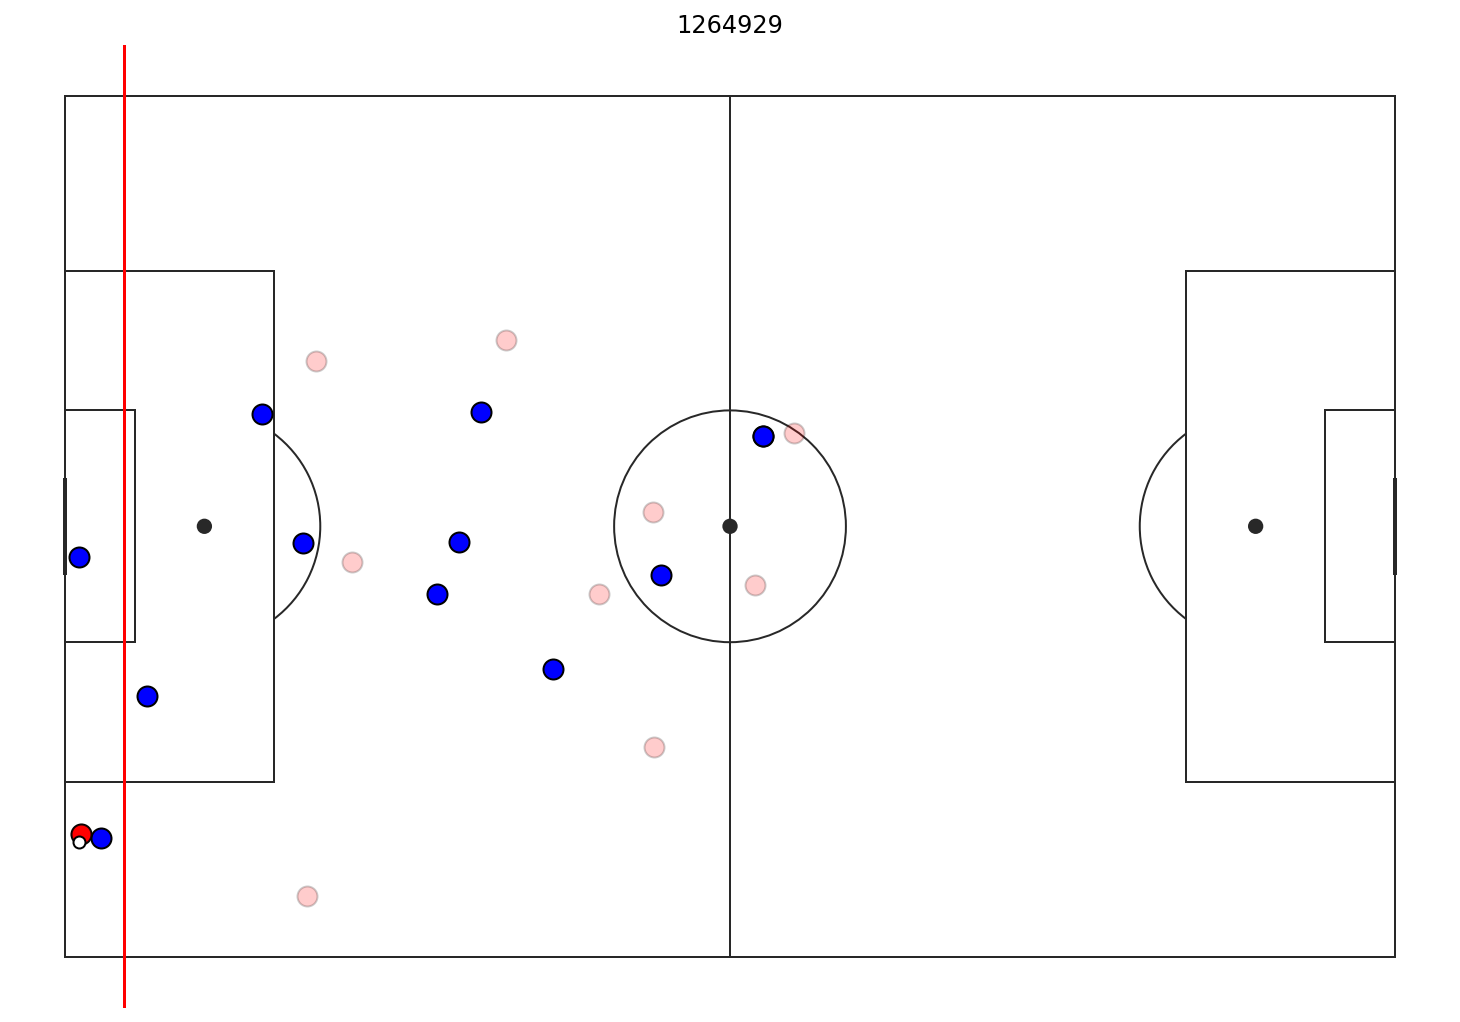

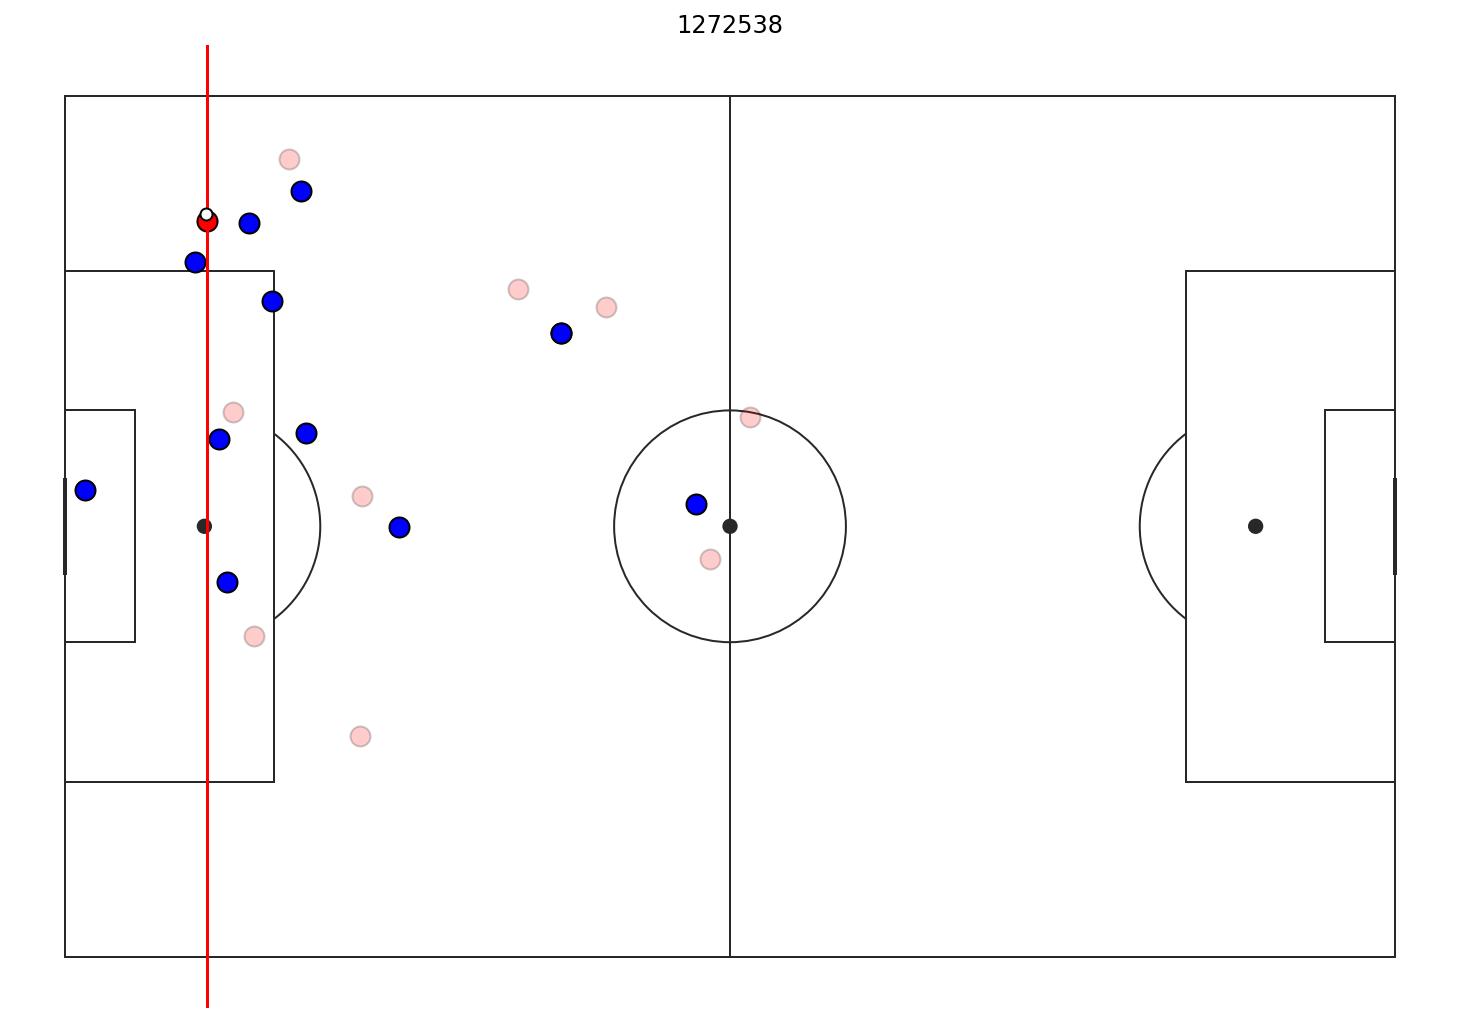

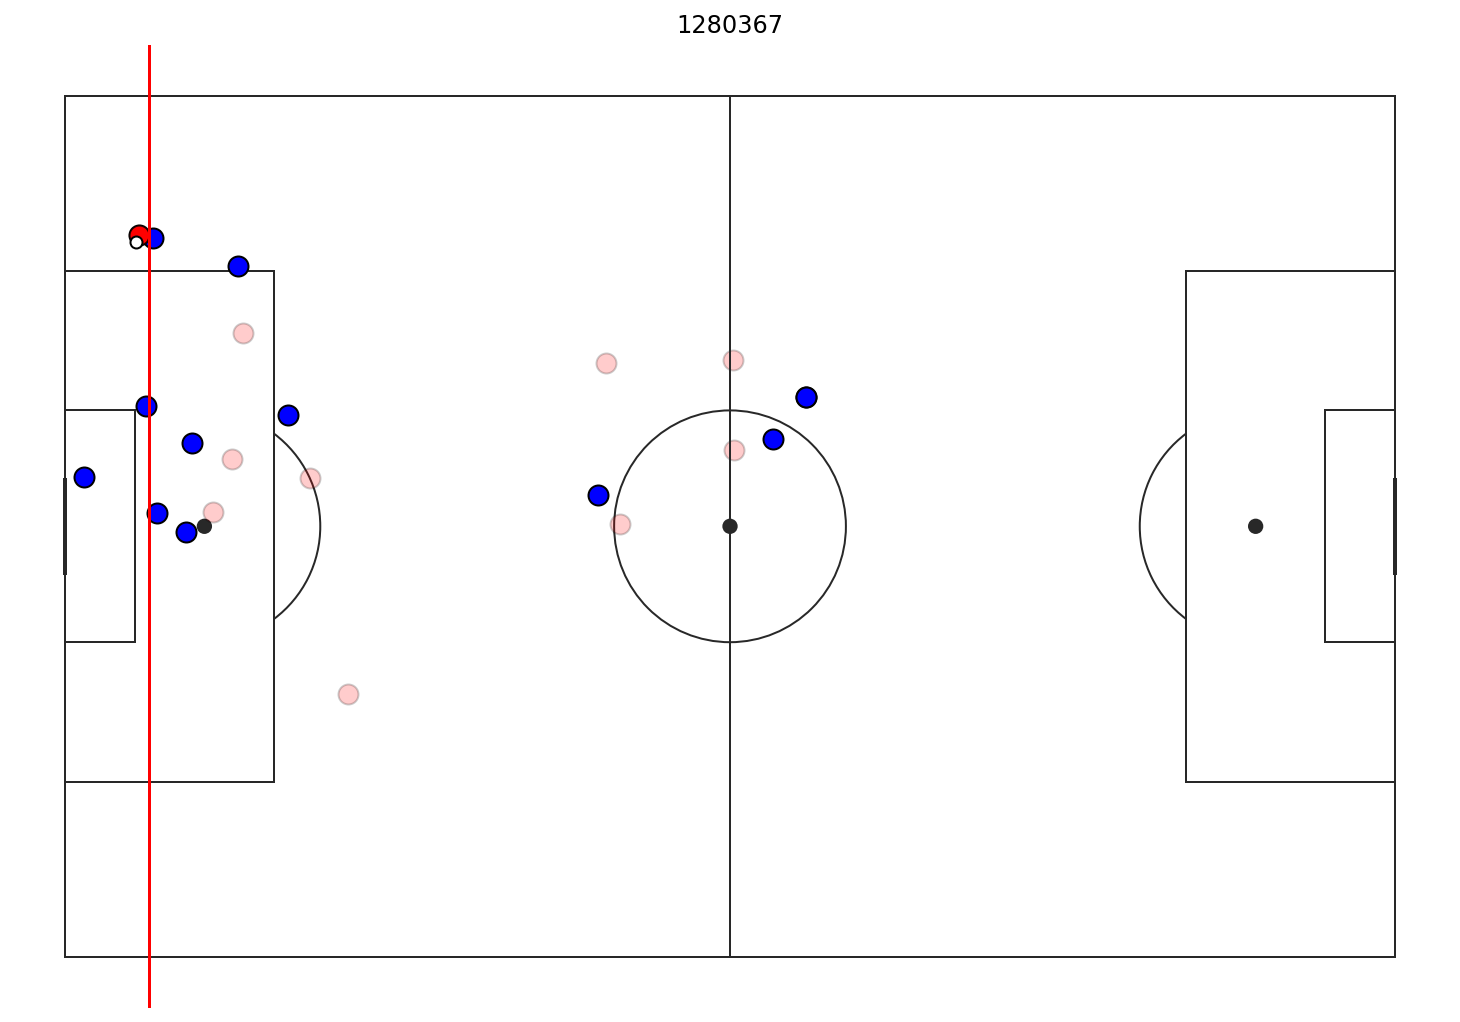

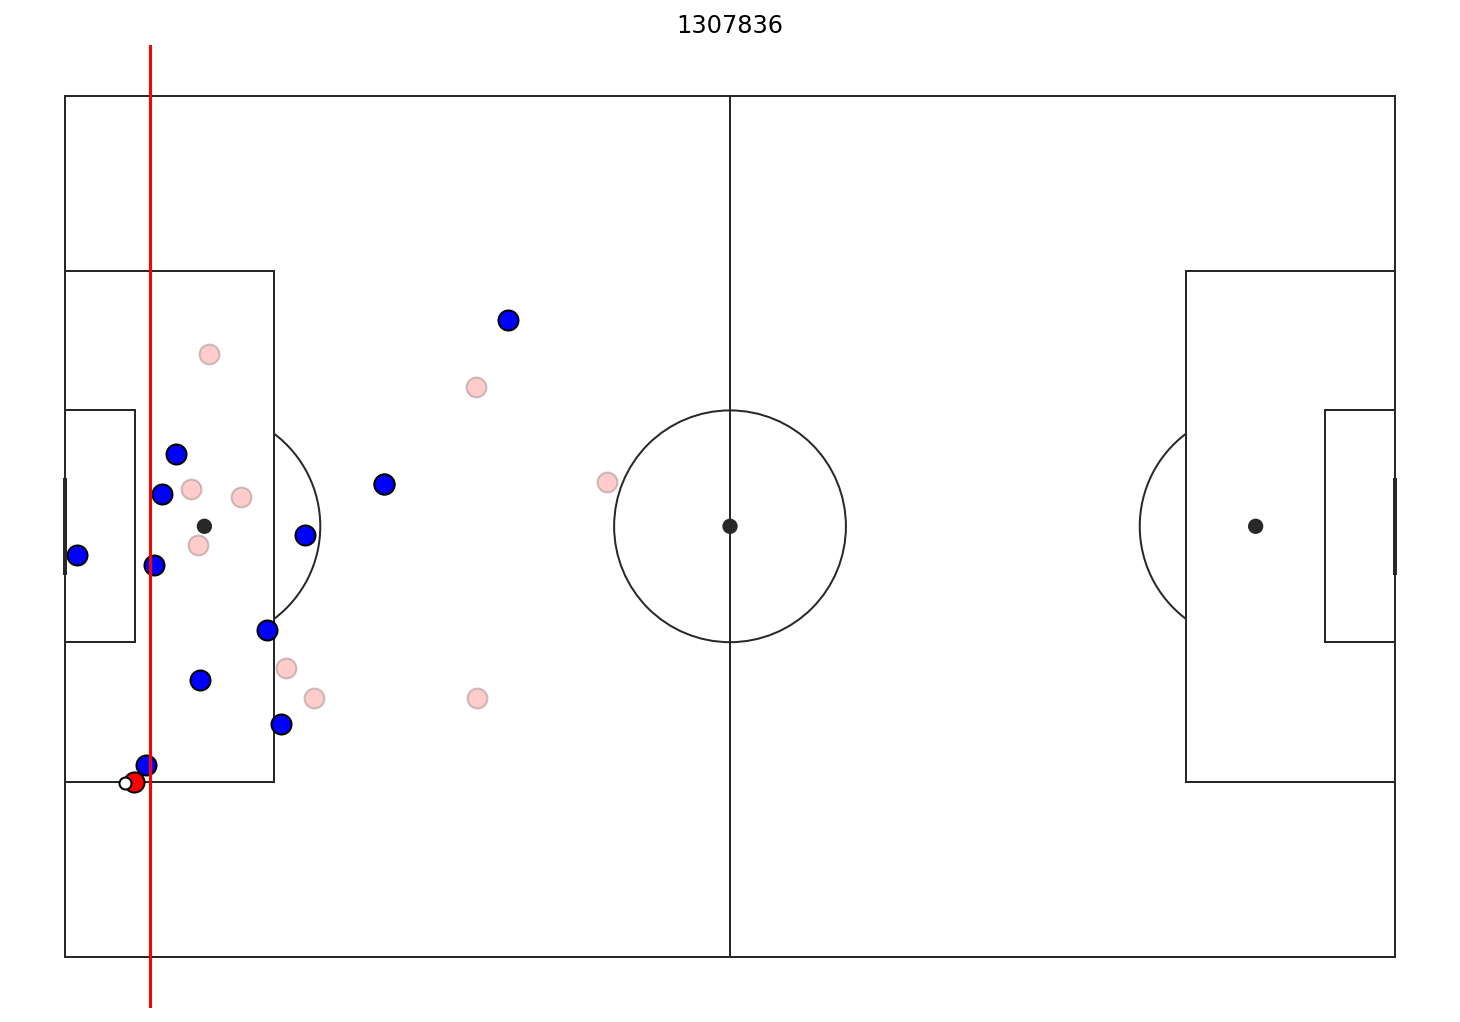

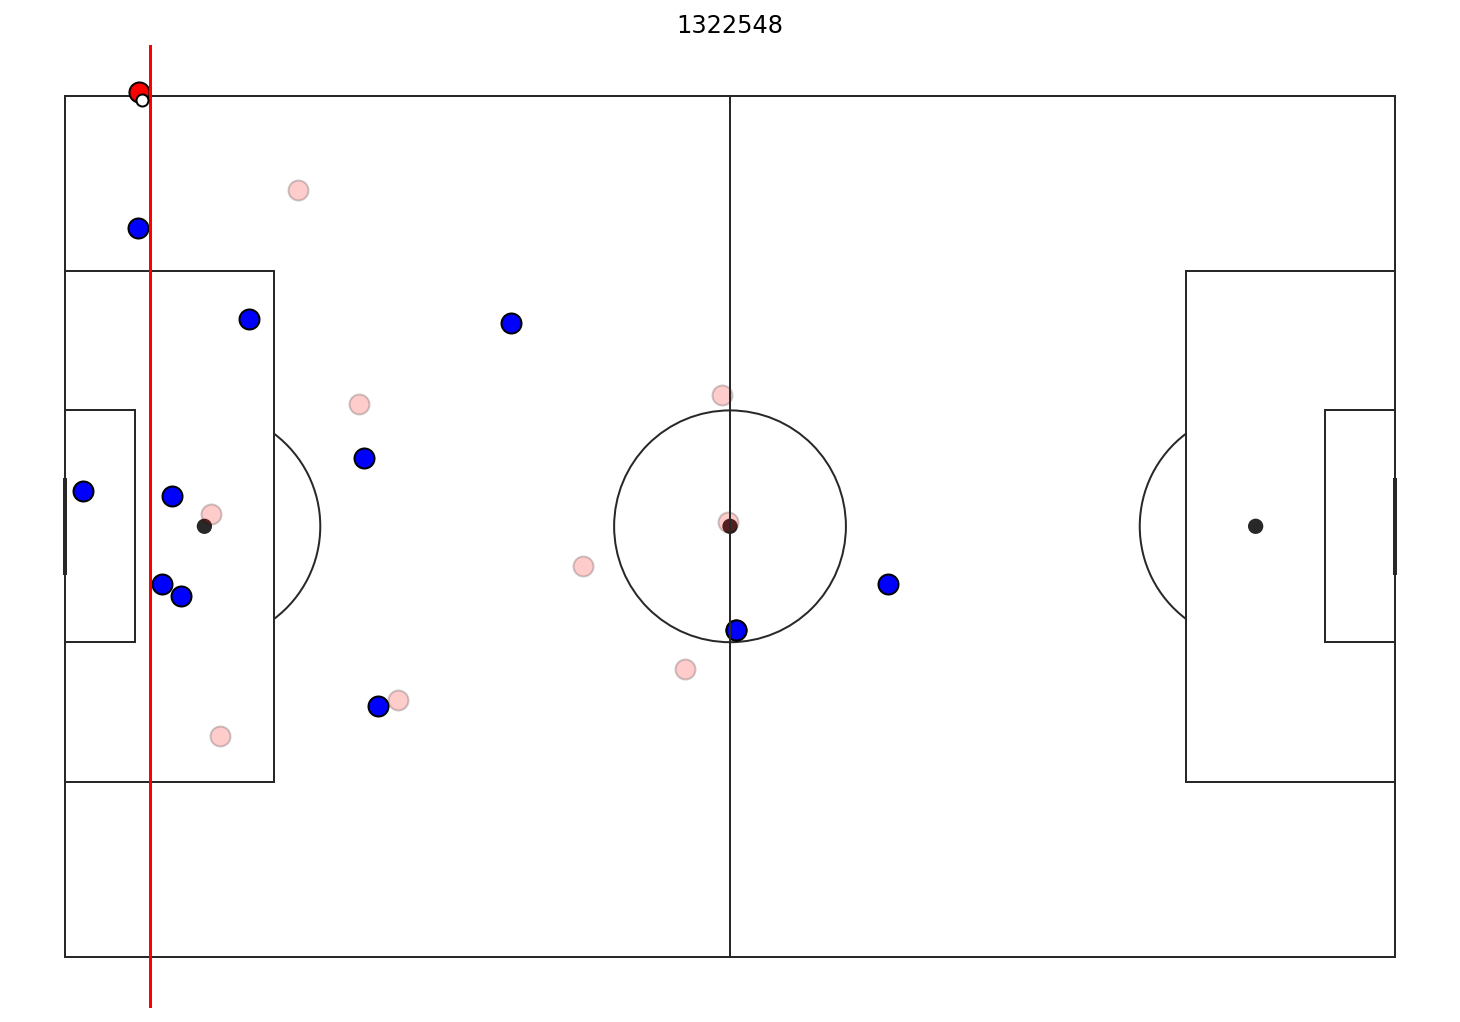

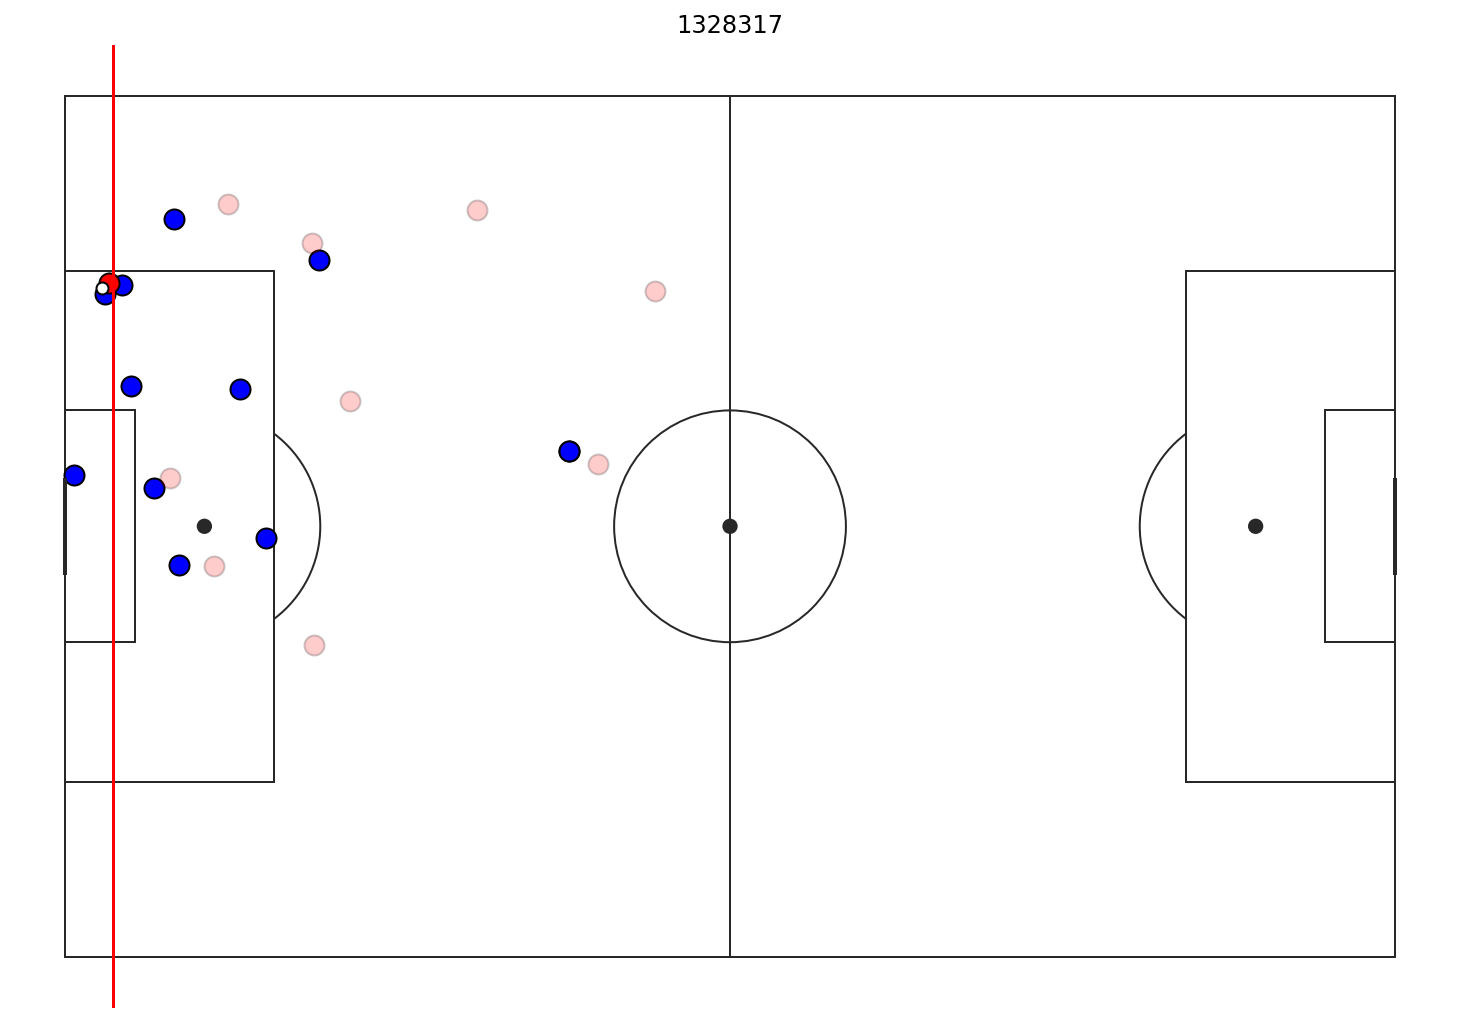

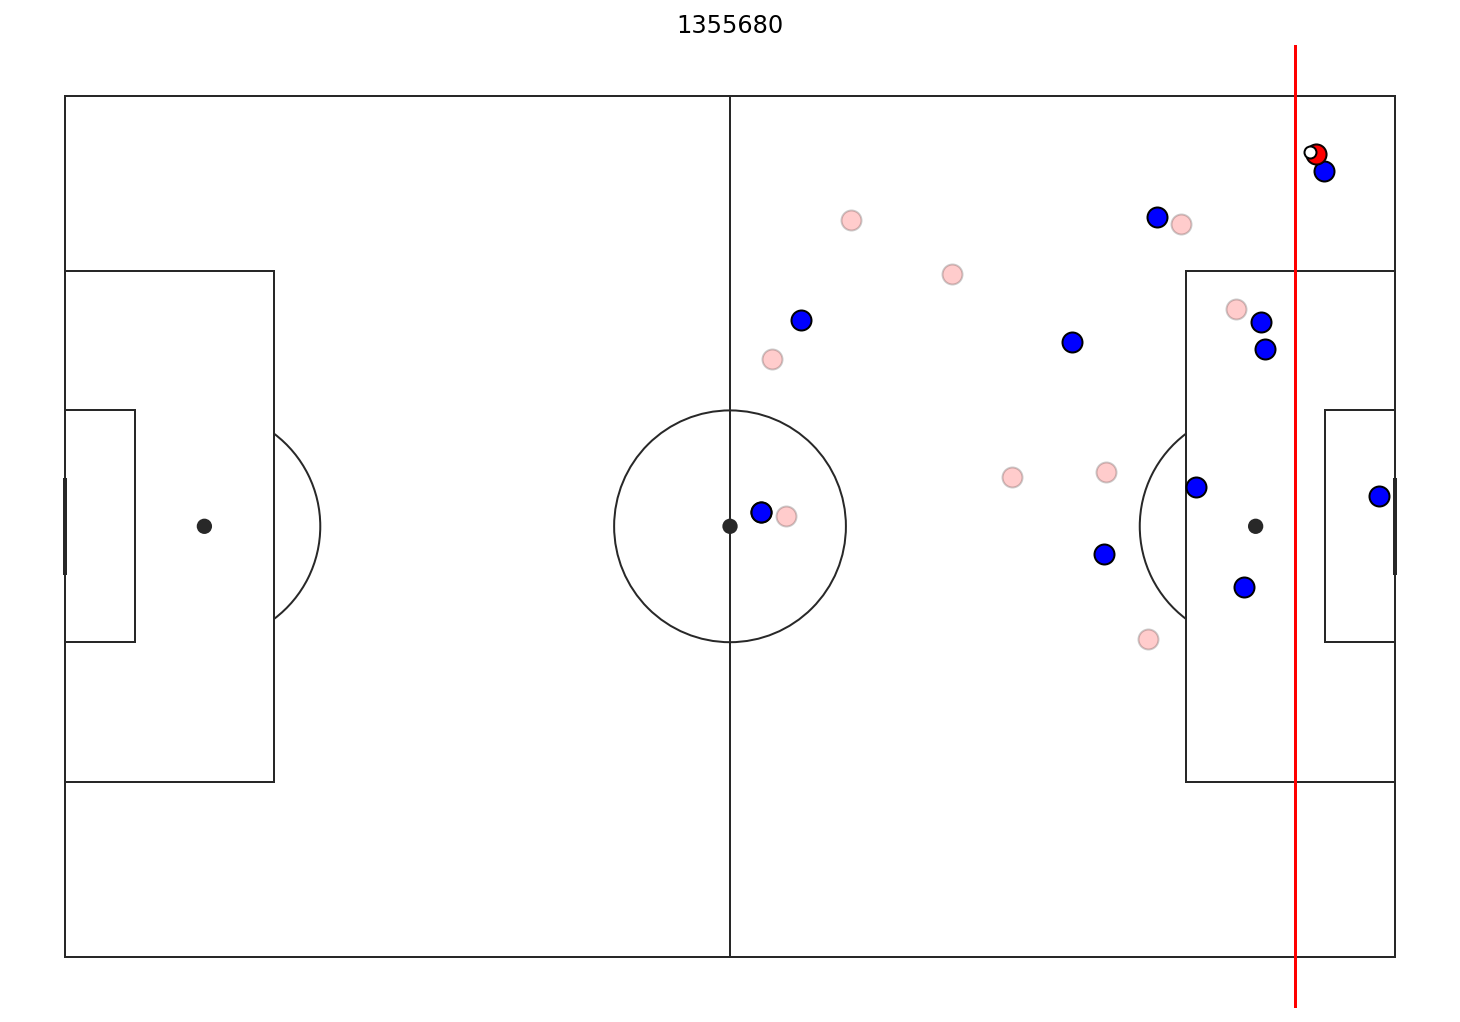

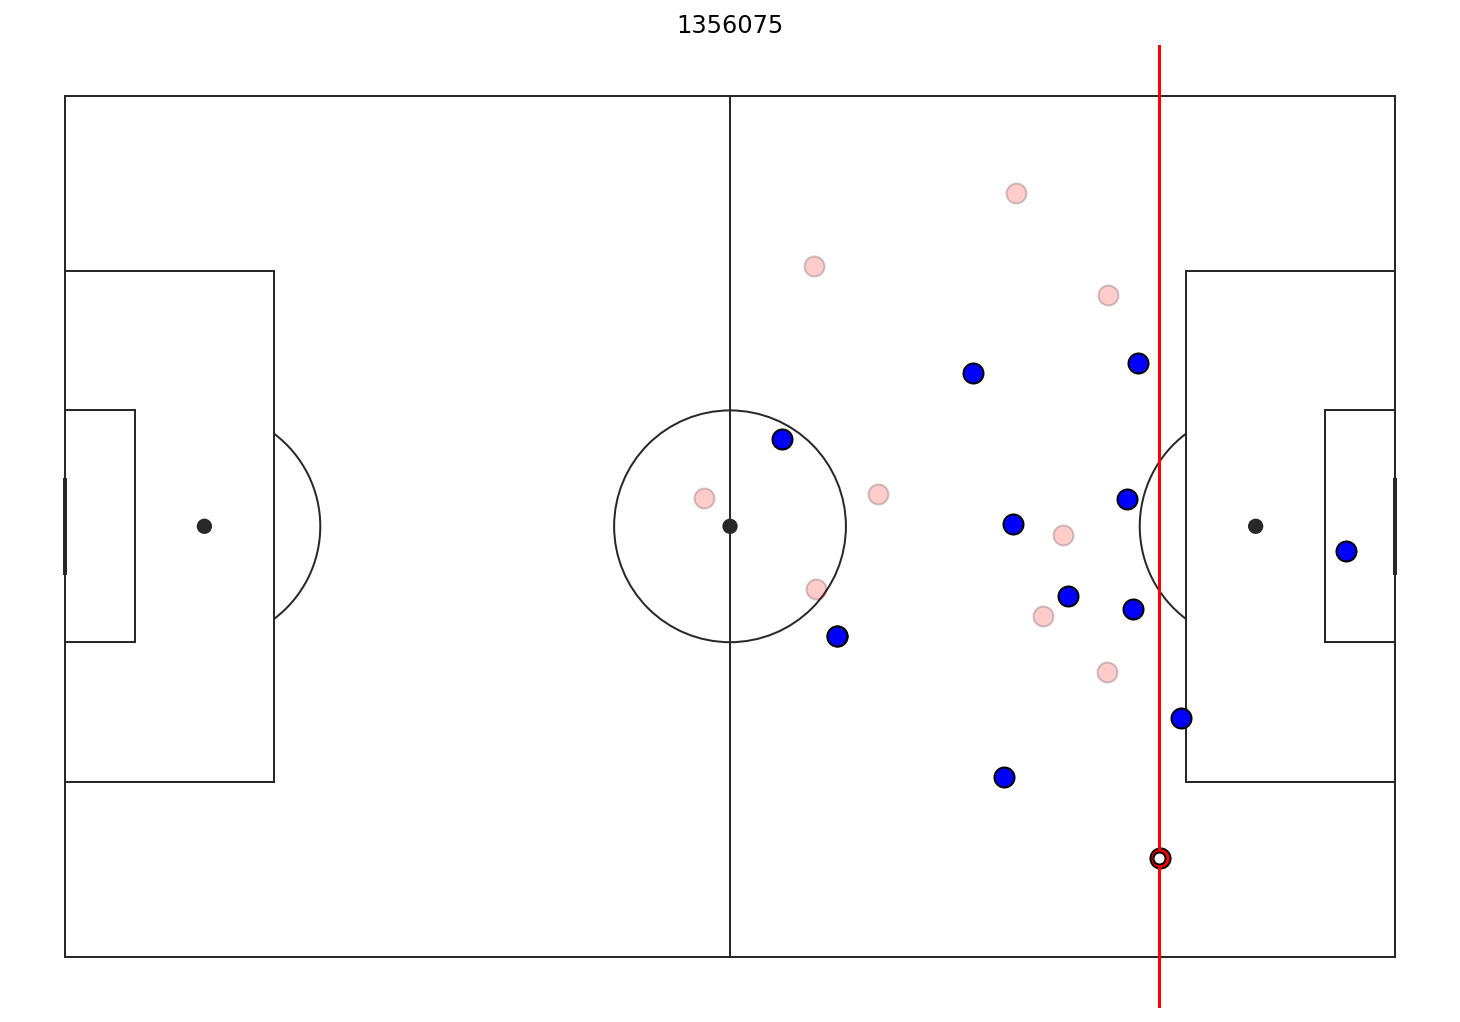

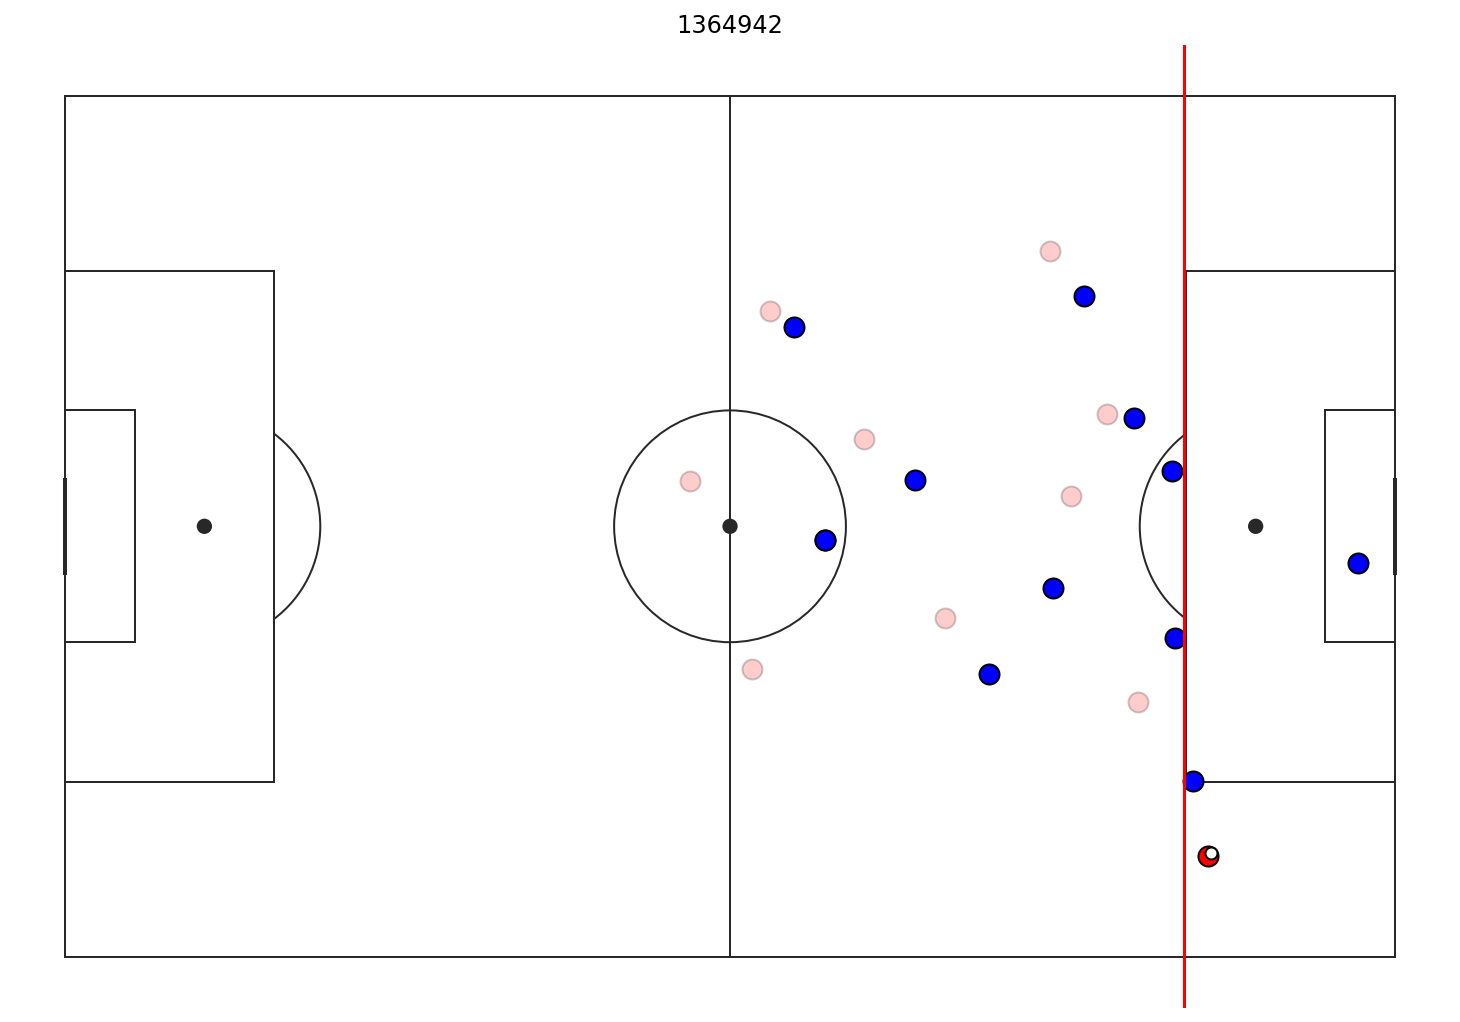

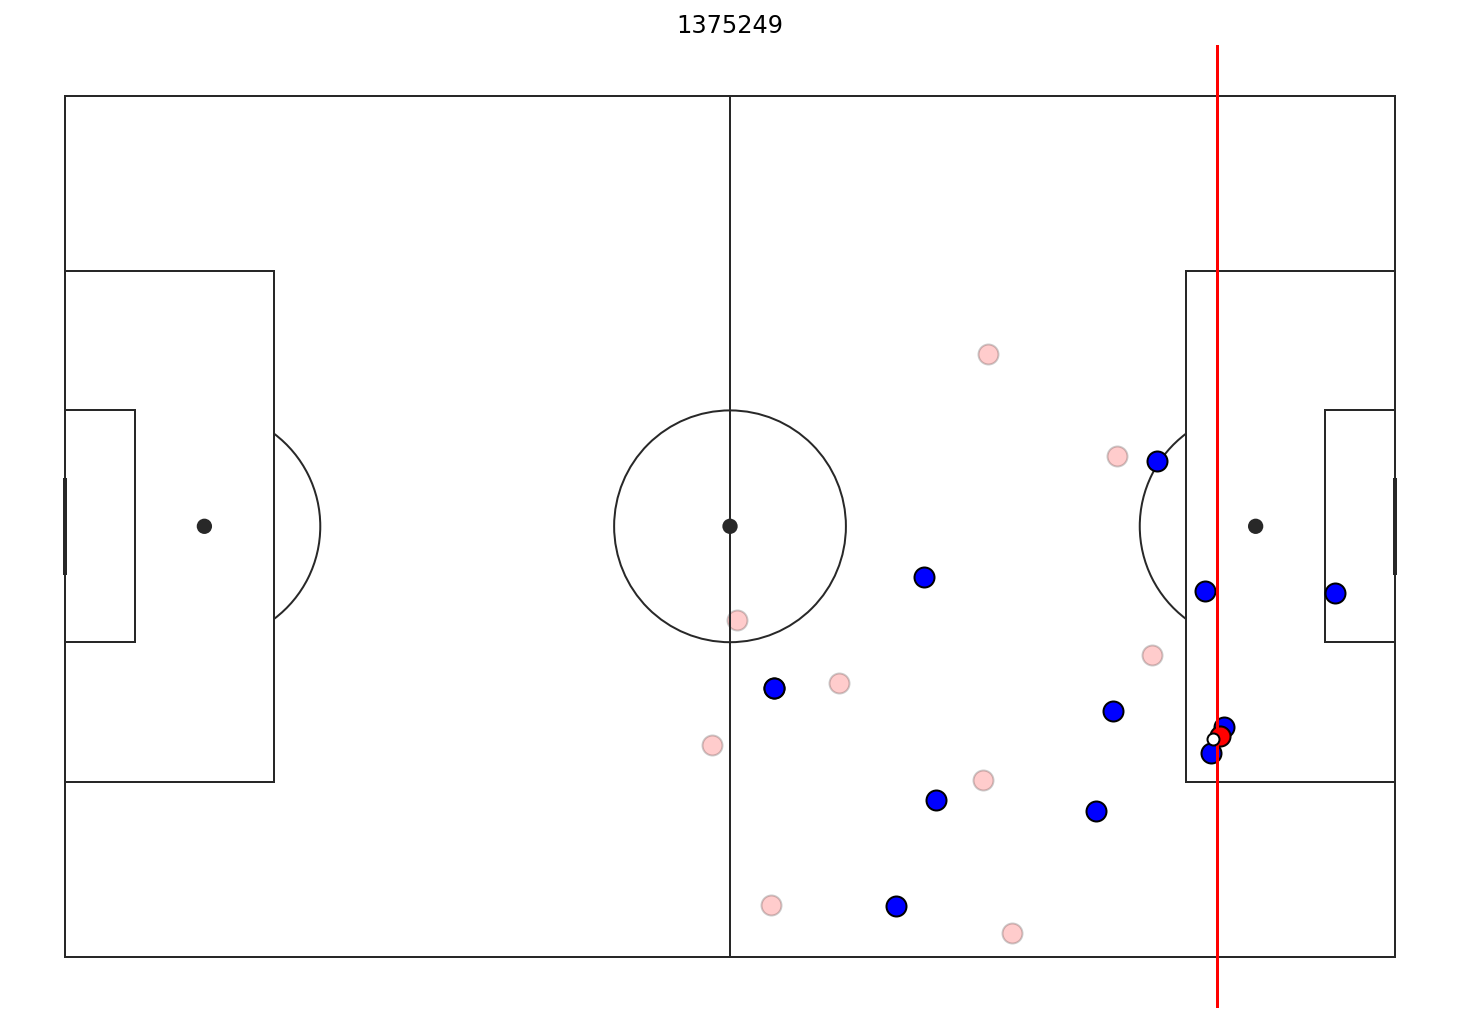

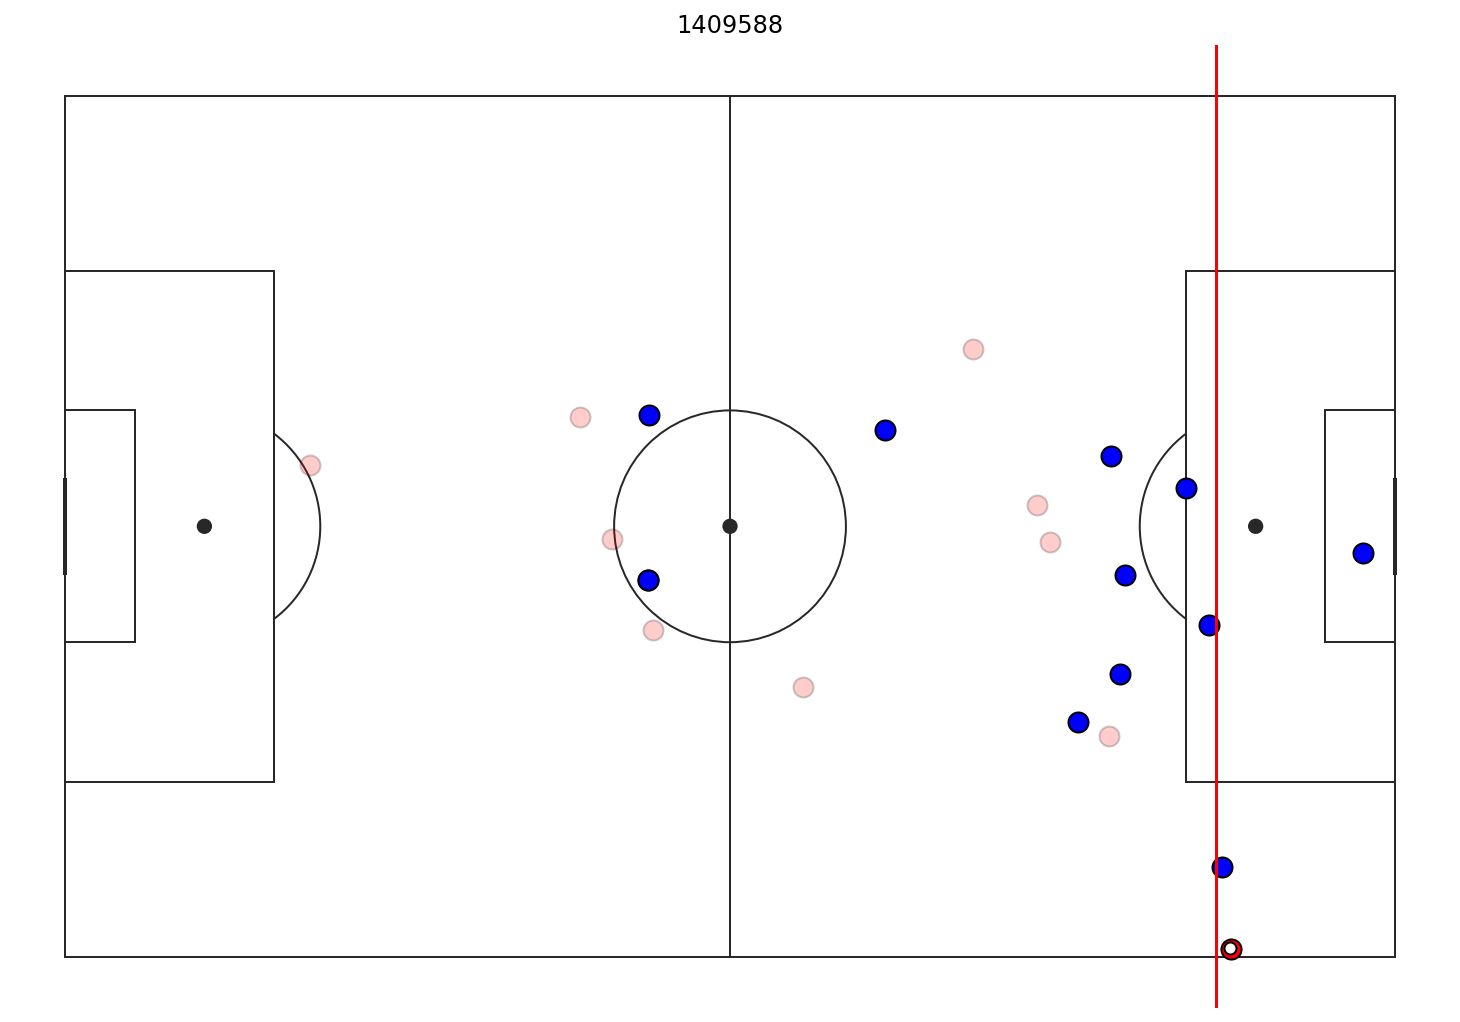

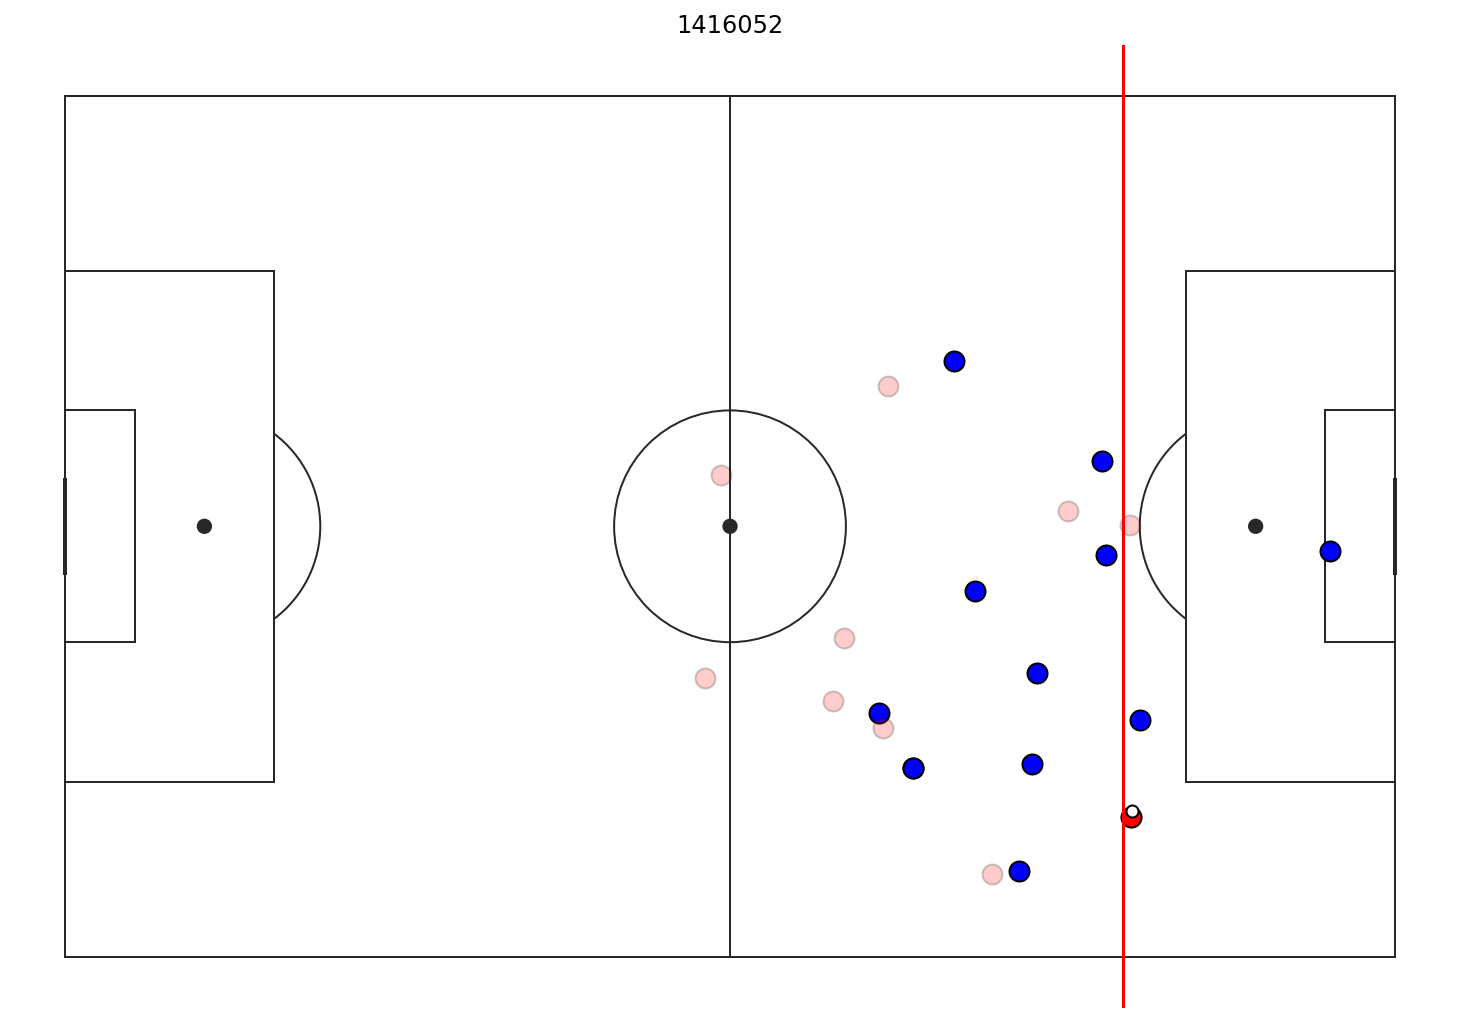

In [13]:

for k in list(range(len(break_summary))):


    ## test line break with back_line 
    playa = break_summary.iloc[k]['player_id']
    fra = break_summary.iloc[k]['frameID']

    frame___ = tracking[(tracking['frameID'] == fra)].reset_index(drop=True)
    p_fra = frame___[frame___['player_id'] == playa].reset_index(drop=True)
    t_fra = frame___[frame___['team'] == FCN_team].reset_index(drop=True)
    b_fra = frame___[frame___['team'] == 10].reset_index(drop=True)
    o_fra = frame___[(frame___['frameID'] == fra) & (frame___['team'] != 10) & (frame___['team'] != FCN_team)].reset_index(drop=True)

    # print(o_fra)
    pitch = Pitch(pitch_type='tracab',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
        pitch_width=68,pitch_length=105,stripe=True,goal_type='line',axis=False,label=True)
    fig, ax = pitch.draw()


    # calc def line

    if att_dir == o_fra.iloc[0]['attacking_direction']:
        temp_seg = o_fra.sort_values(by='x', ascending=False).reset_index(drop=True)[['x']]
    else: 
        temp_seg = o_fra.sort_values(by='x', ascending=True).reset_index(drop=True)[['x']]

    def_line_x = temp_seg.iloc[1:3]['x'].mean() # append the defensive last line


    ax.plot(p_fra.x, p_fra.y, 'ko', ms=10,markerfacecolor='red', zorder=2) #red/maroon
    ax.plot(t_fra.x, t_fra.y, 'ko', ms=10,markerfacecolor='red', zorder=2, alpha =.2) #red/maroon
    ax.plot(b_fra.x, b_fra.y, 'ko', ms=6,markerfacecolor='white', zorder=4) #red/maroon
    ax.plot(o_fra.x, o_fra.y, 'ko', ms=10,markerfacecolor='blue', zorder=1) #red/maroon
    plt.title(str(fra))
    plt.axvline(x = def_line_x, color = "red")
    plt.show()


    # print(p_fra)
    # print(o_fra)

## The Overload Framework


We look to create overloads in wide areas, this is classified within .... 

In [24]:

ol_sum_start = []
ol_sum_end = []
ol_sum_type = []
ol_sum_side = []
ol_sum_lb_sequence_id = []
ol_sum_overload_id = []
ol_sum_duration = []
 

for iii in range(len(lb_sequence_summary)):
# grab a segment of tracking for the lb_segment
    lg_seg_idx = iii
    lb_select = lb_sequence_summary.iloc[lg_seg_idx]

    lb_seg = tracking[tracking['frameID'].between(lb_select.frameID_start,lb_select.frameID_end)].reset_index(drop=True)

    ball_seg = lb_seg[lb_seg['team'] == 10].reset_index()
    team0_seg = lb_seg[lb_seg['team'] != FCN_team].reset_index()
    team0_seg = team0_seg[team0_seg['team'] != 10].reset_index()
    team1_seg = lb_seg[lb_seg['team'] == FCN_team].reset_index()


    ## work out the wide zones 

    ''' 
    Attcking direction of 1 means the team is defending the goal -x and attacking the goal +x. 
    An attacking direction of -1 means the team is defending the goal +x and attacking the goal -x.
    '''

    lb_att_dir = team1_seg.iloc[0]['attacking_direction']

#     print("att_dir", lb_att_dir)

    centre_circle_diameter = 915
    wide_area_y_width = 2015

    if lb_att_dir == 1:

        wide_left_xmin = 0 + centre_circle_diameter
        wide_left_xmax = (tracking_meta['pitch_x'] * 100)/2
        wide_left_ymin = wide_area_y_width
        wide_left_ymax = (tracking_meta['pitch_y'] * 100)/2

        wide_right_xmin = 0 + centre_circle_diameter
        wide_right_xmax = (tracking_meta['pitch_x'] * 100)/2 
        wide_right_ymin = - (tracking_meta['pitch_y'] * 100)/2 
        wide_right_ymax = -wide_area_y_width


    elif lb_att_dir == -1:

        wide_left_xmin = -(tracking_meta['pitch_x'] * 100)/2
        wide_left_xmax = 0 - centre_circle_diameter
        wide_left_ymin = - (tracking_meta['pitch_y'] * 100)/2 
        wide_left_ymax = -wide_area_y_width

        wide_right_xmin = -(tracking_meta['pitch_x'] * 100)/2
        wide_right_xmax = 0 - centre_circle_diameter
        wide_right_ymin = wide_area_y_width
        wide_right_ymax = (tracking_meta['pitch_y'] * 100)/2

    else:
        print("ERROR WITH ATTACKING DIRECTION")


    frames_list = []
    wide_left_list = []
    wide_right_list = []

    for bf in list(set(ball_seg.frameID)):

        row_ = ball_seg[ball_seg['frameID'] == bf].reset_index(drop=True).iloc[0]

        if (row_['y'] >= wide_left_ymin) and (row_['y'] <= wide_left_ymax):
            if (row_['x'] >= wide_left_xmin) and (row_['x'] <= wide_left_xmax):
                wide_left_list.append(True)
            else: 
                wide_left_list.append(False)
        else: 
            wide_left_list.append(False)

        if (row_['y'] >= wide_right_ymin) and (row_['y'] <= wide_right_ymax):
            if (row_['x'] >= wide_right_xmin) and (row_['x'] <= wide_right_xmax):
                wide_right_list.append(True)
            else: 
                wide_right_list.append(False)
        else: 
            wide_right_list.append(False)

        frames_list.append(bf)

    overload_calcs = pd.DataFrame(
        {'frameID': frames_list,
         'wide_right': wide_right_list,
         'wide_left': wide_left_list
        })


    # check for overload in wide_left 

    overload_calcs_left = overload_calcs[overload_calcs['wide_left'] == True].frameID
    overload_left_list = []
    overload_left_type_list = []

    for f in overload_calcs.frameID:

        if overload_calcs[overload_calcs['frameID'] == f].reset_index(drop=True).iloc[0]['wide_left'] == True:

            fcn = team1_seg[team1_seg['frameID'] == f].reset_index(drop=True)
            oppo = team0_seg[team1_seg['frameID'] == f].reset_index(drop=True)

            ## count FCN players 
            fcn_ = fcn[(fcn['y']  >= wide_left_ymin) & (fcn['y'] <= wide_left_ymax)]
            fcn_ = fcn_[(fcn_['x'] >= wide_left_xmin) & (fcn_['x'] <= wide_left_xmax)]

            ## count FCN players 
            oppo_ = oppo[(oppo['y']  >= wide_left_ymin) & (oppo['y'] <= wide_left_ymax)]
            oppo_ = oppo_[(oppo_['x'] >= wide_left_xmin) & (oppo_['x'] <= wide_left_xmax)]


            if (len(fcn_) >= len(oppo_)):
                if len(fcn_) >= 3:
                    overload_left_list.append(True)
                    overload_left_type_list.append(str(len(fcn_)) + "v" + str(len(oppo_)))
                else: 
                    overload_left_list.append(False)
                    overload_left_type_list.append("")
            else:
                overload_left_list.append(False)
                overload_left_type_list.append("")
        else:
            overload_left_list.append(False)    
            overload_left_type_list.append("")


    overload_calcs['left_overload'] = overload_left_list
    overload_calcs['left_overload_type'] = overload_left_type_list

    ### right
    overload_calcs_right = overload_calcs[overload_calcs['wide_right'] == True].frameID
    overload_right_list = []
    overload_right_type_list = []

    for f in overload_calcs.frameID:

        if overload_calcs[overload_calcs['frameID'] == f].reset_index(drop=True).iloc[0]['wide_right'] == True:

            fcn = team1_seg[team1_seg['frameID'] == f].reset_index(drop=True)
            oppo = team0_seg[team1_seg['frameID'] == f].reset_index(drop=True)

            ## count FCN players 
            fcn_ = fcn[(fcn['y']  >= wide_right_ymin) & (fcn['y'] <= wide_right_ymax)]
            fcn_ = fcn_[(fcn_['x'] >= wide_right_xmin) & (fcn_['x'] <= wide_right_xmax)]

            ## count FCN players 
            oppo_ = oppo[(oppo['y']  >= wide_right_ymin) & (oppo['y'] <= wide_right_ymax)]
            oppo_ = oppo_[(oppo_['x'] >= wide_right_xmin) & (oppo_['x'] <= wide_right_xmax)]


            if (len(fcn_) >= len(oppo_)):
                if len(fcn_) >= 3:
                    overload_right_list.append(True)
                    overload_right_type_list.append(str(len(fcn_)) + "v" + str(len(oppo_)))
                else: 
                    overload_right_list.append(False)
                    overload_right_type_list.append("")
            else:
                overload_right_list.append(False)
                overload_right_type_list.append("")
        else:
            overload_right_list.append(False)    
            overload_right_type_list.append("")


    overload_calcs['right_overload'] = overload_right_list
    overload_calcs['right_overload_type'] = overload_right_type_list
    
    overload_calcs2 = overload_calcs[(overload_calcs['left_overload'] == True) | (overload_calcs['right_overload'] == True)].reset_index(drop=True)
    
    ## combine the left and right valued just to side and type
    side_list = []
    type_list = []
    
    for j in list(range(len(overload_calcs2))):
    
        if overload_calcs2.iloc[j].left_overload == True:
            side_list.append("left")
            type_list.append(overload_calcs2.iloc[j].left_overload_type)
        else:
            side_list.append("right")
            type_list.append(overload_calcs2.iloc[j].right_overload_type)
    
    overload_calcs2['type'] = type_list
    overload_calcs2['side'] =  side_list  
    
    ## reduce the calcs to just the essentials 
    overload_calcs2 = overload_calcs2[['frameID', 'type', 'side']]
    overload_calcs2['lb_sequence_id'] = lb_select.lb_sequence_id
    
    if len(overload_calcs2) > 0:
        ## add the id 
        overload_id = 1
        overload_id_list = [str(lb_select.lb_sequence_id) + "_" + str(1)]

        for j in list(range(1, len(overload_calcs2))):

            if (overload_calcs2.iloc[j].frameID - overload_calcs2.iloc[j-1].frameID) <= 50:
                overload_id_list.append(str(overload_calcs2.iloc[j].lb_sequence_id) + "_" + str(overload_id))
            else:
                overload_id += 1
                overload_id_list.append(str(overload_calcs2.iloc[j].lb_sequence_id) + "_" + str(overload_id))

        overload_calcs2['overload_id'] = overload_id_list
        
    
        for g in list(set(overload_calcs2.overload_id)):  
    
            ol_sum_start.append(overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].min())
            ol_sum_end.append(overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].max())
            ol_sum_type.append(overload_calcs2[overload_calcs2['overload_id'] == g].reset_index(drop=True).iloc[0]['type'])
            ol_sum_side.append(overload_calcs2[overload_calcs2['overload_id'] == g].reset_index(drop=True).iloc[0]['side'])
            ol_sum_lb_sequence_id.append(overload_calcs2.iloc[0]['lb_sequence_id'])
            ol_sum_overload_id.append(g)
            ol_sum_duration.append(overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].max() - overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].min())


overload_results = pd.DataFrame({'start': ol_sum_start, 
                                'end': ol_sum_end, 
                                'type': ol_sum_type, 
                                'side': ol_sum_side, 
                                'lb_sequence_id': ol_sum_lb_sequence_id, 
                                'strategy_id': ol_sum_overload_id, 
                                'duration': ol_sum_duration})

overload_results = overload_results[overload_results['duration'] > 50].reset_index(drop=True)


overload_results['strategy_id'] = ["ol_" + f for f in overload_results['strategy_id']]
overload_results['strategy_type'] = "overload"

#print("overload_results - head")
#print(overload_results)


C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [15]:
# events = add_all_time_syncs(events, tracking_meta)
# shots_frames = list(events[(events.type_id.isin(['13','14', '15', '16', '60'])) & (events['team_id'] == '2592')].reset_index(drop=True)['frameID'])


# ### decide is a breakthrough happened within x seconds
# break_frame_scope = 75 # 3 second scope 
# shot_frame_scope = 250 # 5 second scope 


# break_from_overload = []
# shot_occured = []

# for v in list(range(len(overload_results))):
    
#     search_scope = list(range(overload_results.iloc[v].start, overload_results.iloc[v].end + break_frame_scope))
    
#     break_through = False
    
#     for h in list(break_summary['frameID']):
        
#         if h in search_scope:
            
#             break_through = True
            
#     break_from_overload.append(break_through)
    
#     search_scope = list(range(overload_results.iloc[v].start, overload_results.iloc[v].end + shot_frame_scope))

#     shot_happened = False
    
#     for h in shots_frames:
        
#         if h in search_scope:
            
#             shot_happened = True
            
#     shot_occured.append(shot_happened)
    

# overload_results['break_through'] = break_from_overload
# overload_results['shot_occured'] = shot_occured


In [ ]:
 HTML(animate_shot(1719087,1719303,FCN_team).to_html5_video())

In [27]:
def animate_run(starting_frame, ending_frame, FCN_team, pp):

    ##### Animate the Section to Understand 
    from matplotlib import animation
    from pitch import Pitch

    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='tracab',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
                  pitch_width=68,pitch_length=105,stripe=True,goal_type='line',axis=False,label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=6,markerfacecolor='pink',zorder=20)
    team_0, = ax.plot([], [], 'ko', ms=10,markerfacecolor='blue',zorder=10) #red/maroon
    team_1, = ax.plot([], [], 'ko', ms=10,markerfacecolor='red', alpha = 0.3, zorder=9) #purple
    def_centroid, = ax.plot([], [], 'ko', ms=10,markerfacecolor='green', zorder=8) #purple
    att_centroid, = ax.plot([], [], 'ko', ms=10,markerfacecolor='purple', zorder=8) #purple
    team_1p, = ax.plot([], [], 'ko', ms=10,markerfacecolor='red',zorder=3) #purple


    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        def_centroid.set_data([], [])
        att_centroid.set_data([], [])
        team_1p.set_data([], [])


        return ball, team_0, team_1, team_1p, def_centroid, att_centroid

    # animation function of dataframes' list
    def animate(i):

        frame_ = tracking[tracking['frameID'] == frames_to_animate[i]]
        ball_ = frame_[frame_['team'] == 10].reset_index()
        team0_ = frame_[frame_['team'] != FCN_team].reset_index()
        team0_ = team0_[team0_['team'] != 10].reset_index()
        team1_ = frame_[frame_['team'] == FCN_team].reset_index()
        team1p_ = frame_[frame_['player_id'] == pp].reset_index()


        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.iloc[0]['x'], ball_.iloc[0]['y'])

        # set the player data using the frame id
        team_0.set_data(team0_.x,team0_.y)
        team_1.set_data(team1_.x,team1_.y)
        def_centroid.set_data(team0_.x.mean(),team0_.y.mean())
        att_centroid.set_data(team1_.x.mean(),team1_.y.mean())
        team_1p.set_data(team1p_.x,team1p_.y)



        ax.set_title(str(frames_to_animate[i]))
        
        
#         xmin = - (tracking_meta['pitch_x'] / 2) * 100
#         centroid_min = xmin + 1500
#         centroid_max = xmin + 3000



        #plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 1500, color = "red")
        #plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 3000, color = "red")


        plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) -1500, color = "red")
        plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) - 3000, color = "red")



        return ball, team_0, team_1, def_centroid, att_centroid, team_1p
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    # anim.save('demo.mp4',dpi=72, fps=6,extra_args=['-vcodec', 'libx264'])
    return(anim)

## Sideways Spread

In [16]:
spread_sum_start = []
spread_sum_end = []
spread_sum_lb_sequence_id = []

ball_speed_threshold = 1200
y_change_threshold = 30


for iii in list(range(len(lb_sequence_summary))):


    # for iii in range(len(lb_sequence_summary)):
    # grab a segment of tracking for the lb_segment
#     lg_seg_idx = 4
    lg_seg_idx = iii
    lb_select = lb_sequence_summary.iloc[lg_seg_idx]

    lb_seg = tracking[tracking['frameID'].between(lb_select.frameID_start,lb_select.frameID_end)].reset_index(drop=True)

    ball_seg = lb_seg[lb_seg['team'] == 10].reset_index()
    team0_seg = lb_seg[lb_seg['team'] != FCN_team].reset_index()
    team0_seg = team0_seg[team0_seg['team'] != 10].reset_index()
    team1_seg = lb_seg[lb_seg['team'] == FCN_team].reset_index()


    speeds = [float(f) for f in list(ball_seg.speed)]


    frames_ = []
    ys = []
    y_change = []
    ball_speed = []

    for g in list(range(1, len(ball_seg.y))):

        if float(ball_seg.iloc[g].speed) >= ball_speed_threshold:
            if abs(ball_seg.iloc[g].y - ball_seg.iloc[g-1].y) > y_change_threshold:
    #             print("frameID", ,"y", , "change", , "ball speed", )
                frames_.append(ball_seg.iloc[g].frameID) 
                ys.append(ball_seg.iloc[g].y) 
                y_change.append(abs(ball_seg.iloc[g].y - ball_seg.iloc[g-1].y)) 
                ball_speed.append(float(ball_seg.iloc[g].speed)) 

    switch_calcs = pd.DataFrame({'frameID': frames_, 
                                'y': ys, 
                                'y_change': y_change, 
                                'ball_speed': ball_speed})


    switch_id = 1
    switch_id_list = [1]

    for t in list(range(1, len(switch_calcs))):

        if (switch_calcs.iloc[t].frameID - switch_calcs.iloc[t-1].frameID) <=10:
            switch_id_list.append(switch_id)
        else: 
            switch_id = switch_id + 1
            switch_id_list.append(switch_id)

    switch_calcs['switch_id'] = switch_id_list

    start_list = []
    end_list = []
    speed_list = []
    ychange_list = []
    duration_list = []
    y_start_list = []
    x_start_list = []
    switch_id_list = []

    for idd in list(set(switch_calcs.switch_id)):

        temp = switch_calcs[switch_calcs['switch_id'] == idd].reset_index(drop=True)

        duration = (max(temp.frameID) - min(temp.frameID))
        if duration >= 12:

            y_change = abs(temp.iloc[0].y - temp.iloc[len(temp)-1].y)
            if y_change >= 1500:

                start_y = temp.iloc[0].y
                if -2015 <= start_y <= 2015: 

                    end_y = temp.iloc[len(temp)-1].y
                    if end_y > 2015:

                        spread_sum_start.append(min(temp.frameID))
                        spread_sum_end.append(max(temp.frameID))
                        spread_sum_lb_sequence_id.append(lb_select.lb_sequence_id)

                    elif end_y < -2015:
                        spread_sum_start.append(min(temp.frameID))
                        spread_sum_end.append(max(temp.frameID))
                        spread_sum_lb_sequence_id.append(lb_select.lb_sequence_id)
                        

spread_summary = pd.DataFrame({'start': spread_sum_start, 
                            'end': spread_sum_end, 
                            'lb_sequence_id': spread_sum_lb_sequence_id})   


# spread_summary['break_through'] = break_from_overload
# spread_summary['shot_occured'] = shot_occured
spread_summary['strategy_id'] = list(range(len(spread_summary)))
spread_summary['strategy_id'] = ["sp_" + str(f) for f in spread_summary['strategy_id']]
spread_summary['match_id'] = select_your_match
spread_summary['strategy_type'] = "spread"


# spread_summary.head()






In [ ]:
# gap = 25
HTML(animate_shot(1775265,1775314, FCN_team).to_html5_video())

## Runs

In [ ]:
# gap = 25
# HTML(animate_shot(1230377,1230667, FCN_team).to_html5_video())

In [17]:
printer = True
all_run_sequence_summary = pd.DataFrame()

for j in list(range(len(lb_sequence_summary))):
           
              #     RR = 19
    ## select the low block sequence 
    lg_seg_idx = j
#     print(RR)
    lb_select = lb_sequence_summary.iloc[lg_seg_idx]
    
#     print(lb_select.lb_sequence_id)

#     print("/")
        
    ## create a segment of tracking segment
    lb_seg = tracking[(tracking['frameID'].between(lb_select.frameID_start,lb_select.frameID_end + 75)) & (tracking['ball_status'] == "Alive")].reset_index(drop=True)

    ## find defensive line 
    oppo_seg = lb_seg[(lb_seg['team'] != 10) & (lb_seg['team'] != FCN_team)].reset_index(drop=True)

    ## get attacking direction of defensive team 
    att_dir = oppo_seg.iloc[0]['attacking_direction']
    
    ## calculate the defensive line
    frame_list = []
    def_line_list = []

    ## loop through and get the defensive line for each frame
    for fr in list(set(oppo_seg.frameID)):

        frame_list.append(fr) # append the frame 
        temp_seg = oppo_seg[oppo_seg['frameID'] == fr].reset_index(drop=True)

        if att_dir == -1:
            temp_seg = temp_seg.sort_values(by='x', ascending=False).reset_index(drop=True)
        else: 
            temp_seg = temp_seg.sort_values(by='x', ascending=True).reset_index(drop=True)

        def_line_list.append(temp_seg.iloc[1:3]['x'].mean()) # append the defensive last line
    
    ## create a summary dataframe 
    the_view = pd.DataFrame({'frameID': frame_list,'def_line': def_line_list})
    lb_seg['att_dir'] = att_dir # add attacking direction used 
    lb_seg = pd.merge(lb_seg, the_view, on="frameID") # merge together so the defensive line appears as a new column

    ## find defensive line 
    fcn_seg = lb_seg[(lb_seg['team'] != 10) & (lb_seg['team'] == FCN_team)].reset_index(drop=True)

#     if printer:
#         print(fcn_seg.head())    
#         printer = False
#     print("list(set(fcn_seg['player_id']))", len(list(set(fcn_seg['player_id']))))
    
    for player in list(set(fcn_seg['player_id'])):
        
#         print(player, "in", lb_select.lb_sequence_id)
        
        player_seg = fcn_seg[fcn_seg['player_id'] == player].reset_index(drop=True)
        player_seg['next_x'] = player_seg['x'].shift(-1)
#         print("player_seg.iloc[0]['attacking_direction']", player_seg.iloc[0]['attacking_direction'])
        if player_seg.iloc[0]['attacking_direction'] == 1:
            player_seg['direction']=np.where((player_seg['x'] < player_seg['next_x']),1,0)
            player_seg['close_to_def_line']=np.where( ( abs(player_seg['def_line'] - player_seg['x']) <= 500),1,0)
            player_seg['in_front_of_line']=np.where( (player_seg['def_line'] > player_seg['x']),1,0)
            player_seg['run_broken_line']=np.where((player_seg['def_line']< player_seg['x']),1,0)
            player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 75),1,0)
#             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) > 5) ,1,0)
            player_seg['vertical_gain']=np.where( ((player_seg['next_x'] - player_seg['x']) > 10) ,1,0)


        elif player_seg.iloc[0]['attacking_direction'] == -1:
            player_seg['direction']=np.where((player_seg['x'] > player_seg['next_x']),1,0)
            player_seg['close_to_def_line']=np.where( (abs(player_seg['def_line'] - player_seg['x']) <= 500),1,0)
            player_seg['in_front_of_line']=np.where( (player_seg['def_line'] < player_seg['x']),1,0)
            player_seg['run_broken_line']=np.where((player_seg['def_line']>player_seg['x']),1,0)
            player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 75),1,0)
#             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) < -5) ,1,0)
            player_seg['vertical_gain']=np.where( ((player_seg['next_x'] - player_seg['x']) < -10) ,1,0)


        speeds = ['bolt_speed_sprinting' , 'high_speed_sprinting', 'low_speed_sprinting']    
        player_seg['run_speed'] =  np.where((player_seg['speed_class'].isin(speeds)),1,0)
#         player_seg['forward_run_5'] = np.where((  (player_seg['Direction'] == 1)  & (player_seg['vertical_gain_5'] == 1) & (player_seg['dist_to_def_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)
        player_seg['forward_run'] = np.where((  (player_seg['direction'] == 1)  & (player_seg['close_to_def_line'] == 1) & (player_seg['vertical_gain'] == 1) & (player_seg['in_front_of_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)
        
#         if printer:
#             print("'frameID', 'x', 'y', 'vertical_gain', 'on_ball', 'forward_run'")
#             print(player_seg[['frameID', 'x', 'vertical_gain',  'forward_run', 'in_front_of_line', 'close_to_def_line', 'def_line']])    
#             printer = False
#         if lb_select.lb_sequence_id == 17:
            
        print_boi = True
        
        if len(list(set(player_seg.forward_run))) > 1:
#             print("*"*80)
            
            ## bridge gaps in runs of 12 frames 
            run_happening = []
            for ii in list(range(0, len(player_seg) - 12)):
                run_happening.append( int( (1 in list(set(player_seg.iloc[ii:ii+12].forward_run))) == True) )
            player_seg['forward_run2'] = run_happening + list(player_seg.iloc[len(player_seg)-12:len(player_seg)].forward_run)


        
            runs_frameIDs = list(player_seg[player_seg['forward_run2'] == 1].frameID)
            
            gap_threshold = 12 # under 100 frames = 4 seconds 
            run_sequence_id = 1

            run_sequence_id_list = [1]

            for run_frame in range(1,len(runs_frameIDs)):

                    if (runs_frameIDs[run_frame] - runs_frameIDs[run_frame-1]) <= gap_threshold:

                        run_sequence_id_list.append(run_sequence_id)

                    else:
                        run_sequence_id = run_sequence_id + 1
                        run_sequence_id_list.append(run_sequence_id)


            run_sequence_info = pd.DataFrame(
                {'frameID': runs_frameIDs,
                 'run_sequence_id': run_sequence_id_list
                })

            
            start__ = []
            end__ = []
            past_line__ = []
            break_line__ = []
            player_id__ = []
            run_id__ = []
            median_y__ = []
            
            for s in list(set(run_sequence_info.run_sequence_id)):
                
                start_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameID.min()
                end_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameID.max()

                start__.append(start_frame)
                end__.append(end_frame)
                
                run_seg = player_seg[player_seg['frameID'].between(start_frame, end_frame)]
                median_y__.append(round(run_seg.y.median(),0))

                player_id__.append(player)
                run_id__.append(s)

            
            run_sequence_summary = pd.DataFrame(
                {'start': start__,
                 'end': end__,
                 'player_id' : player_id__,
                 'run_id' :run_id__,
                 'median_y':median_y__
                })
            
            
            in_behind_scope = 5
            on_ball_scope = 100 
            
            
            in_behind__ = []
            on_ball__ = [] 
            
            for r in list(range(len(run_sequence_summary))):
                
                run_info = run_sequence_summary.iloc[r]
                in_behind__.append(1 in set(player_seg[player_seg['frameID'].between(run_info.start, run_info.end + in_behind_scope)].run_broken_line))
                on_ball__.append(1 in set(player_seg[player_seg['frameID'].between(run_info.start, run_info.end + on_ball_scope)].on_ball))   

            run_sequence_summary['in_behind'] = in_behind__
            run_sequence_summary['on_ball'] = on_ball__            
            run_sequence_summary['lb_sequence_id'] = lb_select.lb_sequence_id

            all_run_sequence_summary = all_run_sequence_summary.append(run_sequence_summary)

            
all_run_sequence_summary['match_id'] = select_your_match
all_run_sequence_summary['strategy_id'] = ["r_" + str(a) + "_" + str(b) for a,b in zip(all_run_sequence_summary['lb_sequence_id'] , all_run_sequence_summary['run_id'])]
all_run_sequence_summary['strategy_type'] = "run"
all_run_sequence_summary = all_run_sequence_summary.reset_index(drop=True)

del all_run_sequence_summary['run_id']


#all_run_sequence_summary.head()



## Pockets

In [18]:

def dist_to_oppo(segment_, p_pos_):

#     segment_['distance_to_oppo'] = segment_[['x', 'y']].sub(np.array( p_pos_[0], p_pos_[1] )).pow(2).sum(1).pow(0.5)
    return(segment_[['x', 'y']].sub(np.array( p_pos_[0], p_pos_[1] )).pow(2).sum(1).pow(0.5))
#     segment_.distance_to_goal1 = trackingdata.distance_to_goal1.round(2)
#     segment_.distance_to_goal2 = trackingdata.distance_to_goal2.round(2)

#     return(segment_)  
    

In [19]:
xmin = - (tracking_meta['pitch_x'] / 2) * 100
xmax = (tracking_meta['pitch_x'] / 2) * 100


all_pocket_sequence_summary = pd.DataFrame()




for j in list(range(len(lb_sequence_summary))):
              #     RR = 19
    ## select the low block sequence 
    lg_seg_idx = j
#     print(RR)
    lb_select = lb_sequence_summary.iloc[lg_seg_idx]
#     print(j)
#         
    ## create a segment of tracking segment
    lb_seg = tracking[(tracking['frameID'].between(lb_select.frameID_start,lb_select.frameID_end)) & (tracking['ball_status'] == "Alive")].reset_index(drop=True)

    ## find defensive line 
    oppo_seg = lb_seg[(lb_seg['team'] != 10) & (lb_seg['team'] != FCN_team)].reset_index(drop=True)

    ## get attacking direction of defensive team 
    att_dir = oppo_seg.iloc[0]['attacking_direction']
    
    ## calculate the defensive line
    frame_list = []
    def_line_list = []

    ## loop through and get the defensive line for each frame
    for fr in list(set(oppo_seg.frameID)):

        frame_list.append(fr) # append the frame 
        temp_seg = oppo_seg[oppo_seg['frameID'] == fr].reset_index(drop=True)

        if att_dir == -1:
            temp_seg = temp_seg.sort_values(by='x', ascending=False).reset_index(drop=True)
        else: 
            temp_seg = temp_seg.sort_values(by='x', ascending=True).reset_index(drop=True)

        def_line_list.append(temp_seg.iloc[1:3]['x'].mean()) # append the defensive last line
    
    ## create a summary dataframe 
    the_view = pd.DataFrame({'frameID': frame_list,'def_line': def_line_list})
    lb_seg['att_dir'] = att_dir # add attacking direction used 
    lb_seg = pd.merge(lb_seg, the_view, on="frameID") # merge together so the defensive line appears as a new column

    ## find defensive line 
    fcn_seg = lb_seg[(lb_seg['team'] != 10) & (lb_seg['team'] == FCN_team)].reset_index(drop=True)

#     print(fcn_seg.head())    
    
#     print("list(set(fcn_seg['player_id']))", len(list(set(fcn_seg['player_id']))))
    
    fcn_seg['on_ball'] = np.where((fcn_seg['distance_to_ball'] < 75),1,0)
        
    if fcn_seg.attacking_direction[0] == 1:
        fcn_seg['in_pocket_zone'] = np.where((fcn_seg['x'] < fcn_seg['def_line']) &
#                                                 (fcn_seg['x'] > fcn_seg['centroid_x'] - (fcn_seg['def_line'] - fcn_seg['centroid_x'])) & 
                                                (fcn_seg['y'] < 2015) & 
                                                (fcn_seg['x'] > (xmax - 3000)) &
                                                (fcn_seg['x'] < (xmax - 1500)) &
                                                (fcn_seg['y'] > -2015), 1, 0)

    elif fcn_seg.attacking_direction[0] == -1:
        fcn_seg['in_pocket_zone'] = np.where((fcn_seg['x'] > fcn_seg['def_line']) &
#                                                 (fcn_seg['x'] < fcn_seg['centroid_x'] + (abs(fcn_seg['def_line'] - fcn_seg['centroid_x']))) & 
                                                (fcn_seg['y'] < 2015) & 
                                                (fcn_seg['x'] < (xmin + 3000)) &   
                                                (fcn_seg['x'] > (xmin + 1500)) &
                                                (fcn_seg['y'] > -2015), 1, 0)
        
#     xmin 
    
    for player in list(set(fcn_seg[(fcn_seg['on_ball'] == 1) & (fcn_seg['in_pocket_zone'] == 1)]['player_id'])):
        
#         print(player, "in", lb_select.lb_sequence_id)
        
        player_seg = fcn_seg[fcn_seg['player_id'] == player].reset_index(drop=True)
        

        
        frames_to_test = list(player_seg.frameID)
    
        under_pressure_list = []
        centroid__x_ = []
#         centroid__y_ = []
        
    
        for ff in frames_to_test:
            
            temp_player = player_seg[player_seg['frameID'] == ff].reset_index(drop=True)
            p_pos = np.array((temp_player.iloc[0]['x'],temp_player.iloc[0]['y'])) 
            opp_temp = oppo_seg[oppo_seg['frameID'] == ff].reset_index(drop=True)
#             print("-"*10)
#             op_dists = dist_to_oppo(opp_temp[['x','y']], p_pos)
#             print(op_dists)
#             print("-"*10)
            
            op_dists = dist_to_oppo(opp_temp[['x','y']], p_pos)
            
            under_pressure_list.append(sum( np.where((op_dists < 350),1,0)))
            
            centroid__x_.append(round(opp_temp.x.mean(),0))
            
#             print(sum( np.where((op_dists < 350),1,0)), round(oppo_seg[oppo_seg['frameID'] == ff].x.mean(),0), dist_to_oppo(oppo_seg[oppo_seg['frameID'] == ff].reset_index(drop=True)[['x','y']], p_pos).distance_to_oppo)
            
#         for aa in [np.array((a,b)) for a,b in zip(player_seg['x'], player_seg['y'])]:
        
#             op_dists = dist_to_oppo(oppo_seg[oppo_seg['frameID'] == ff].reset_index(drop=True)[['x','y']], aa).distance_to_oppo
#             under_pressure_list.append(sum( np.where((op_dists < 350),1,0)))
            
#             centroid__x_.append(round(oppo_seg[oppo_seg['frameID'] == ff].x.mean(),0))
            
    
    
        player_seg['on_ball'] = np.where((player_seg['distance_to_ball'] < 75),1,0)
        player_seg['under_pressure']= under_pressure_list
        player_seg['centroid_x'] = centroid__x_
#         player_seg['centroid_y'] = centroid__y_
        
        
        ## abs(player_seg['def_line'] - player_seg['centroid_x'])

        
        if player_seg.attacking_direction[0] == 1:
            player_seg['in_pocket_zone'] = np.where((player_seg['x'] < player_seg['def_line']) &
                                                    (player_seg['x'] > player_seg['centroid_x'] - (player_seg['def_line'] - player_seg['centroid_x'])) & 
                                                    (player_seg['x'] > (xmax - 3000)) &
                                                    (player_seg['x'] < (xmax - 1500)) &                                        
                                                    (player_seg['y'] > -2015), 1, 0)
            
        elif player_seg.attacking_direction[0] == -1:
            player_seg['in_pocket_zone'] = np.where((player_seg['x'] > player_seg['def_line']) &
                                                    (player_seg['x'] < player_seg['centroid_x'] + (abs(player_seg['def_line'] - player_seg['centroid_x']))) & 
                                                    (player_seg['x'] < (xmin + 3000)) &   
                                                    (player_seg['x'] > (xmin + 1500)) &                                          
                                                    (player_seg['y'] > -2015), 1, 0)
        
        else:
            print("ERROR")
            
            
        player_seg['in_pocket'] = np.where((player_seg['on_ball'] == 1) & 
                                           (player_seg['under_pressure'] == 0) & 
                                           (player_seg['in_pocket_zone'] == 1), 1,0)
        
        
        if len(set(player_seg['in_pocket'])) > 1:
            
            
            pocket_frameIDs = list(player_seg[player_seg['in_pocket'] == 1].frameID)
            
            gap_threshold = 12 # under 100 frames = 4 seconds 
            pocket_sequence_id = 1

            pocket_sequence_id_list = [1]

            for pocket_frame in range(1,len(pocket_frameIDs)):

                    if (pocket_frameIDs[pocket_frame] - pocket_frameIDs[pocket_frame-1]) <= gap_threshold:

                        pocket_sequence_id_list.append(pocket_sequence_id)

                    else:
                        pocket_sequence_id = pocket_sequence_id + 1
                        pocket_sequence_id_list.append(pocket_sequence_id)


            pocket_sequence_info = pd.DataFrame(
                {'frameID': pocket_frameIDs,
                 'pocket_sequence_id': pocket_sequence_id_list
                })

#             print(pocket_sequence_info)

            start__ = []
            end__ = []
            player_id__ = []
            pocket_id__ = []
            
            for s in list(set(pocket_sequence_info.pocket_sequence_id)):
                
                start_frame = pocket_sequence_info[pocket_sequence_info['pocket_sequence_id'] == s].frameID.min()
                end_frame = pocket_sequence_info[pocket_sequence_info['pocket_sequence_id'] == s].frameID.max()

                start__.append(start_frame)
                end__.append(end_frame)
                
#                 run_seg = player_seg[player_seg['frameID'].between(start_frame, end_frame)]
#                 median_y__.append(round(run_seg.y.median(),0))

                player_id__.append(player)
                pocket_id__.append(s)

            pocket_sequence_summary = pd.DataFrame(
                {'start': start__,
                 'end': end__,
                 'player_id' : player_id__,
                 'pocket_id' :pocket_id__
                })
            
            pocket_sequence_summary['lb_sequence_id'] = lb_select.lb_sequence_id

            
            all_pocket_sequence_summary = all_pocket_sequence_summary.append(pocket_sequence_summary)
#             print(run_sequence_summary)
            
#             for iii in list(range(len(player_seg))):
#                 if player_seg.iloc[iii]['in_pocket'] == 1:
# #                     pass
#                     print(player_seg.iloc[iii].player_id, player_seg.iloc[iii].frameID, player_seg.iloc[iii].in_pocket)


all_pocket_sequence_summary['match_id'] = select_your_match
all_pocket_sequence_summary['strategy_id'] = ["pok_" + str(a) + "_" + str(b) for a,b in zip(all_pocket_sequence_summary['lb_sequence_id'] , all_pocket_sequence_summary['pocket_id'])]
all_pocket_sequence_summary['strategy_type'] = "central_pocket"
all_pocket_sequence_summary = all_pocket_sequence_summary.reset_index(drop=True)




In [20]:
all_pocket_sequence_summary.head(100)


start      end player_id  pocket_id  lb_sequence_id match_id  \
0   1265108  1265108    440089          1               0   984564   
1   1265126  1265148    440089          2               0   984564   
2   1292296  1292298    440089          1               6   984564   
3   1307749  1307754    116187          1               7   984564   
4   1307780  1307780    116187          2               7   984564   
5   1322660  1322697    440089          1              10   984564   
6   1322710  1322720    440089          2              10   984564   
7   1323042  1323047    440089          3              10   984564   
8   1358303  1358310    208695          1              18   984564   
9   1362004  1362006    213398          1              20   984564   
10  1361984  1361984    430368          1              20   984564   
11  1364985  1364988    430368          1              22   984564   
12  1365032  1365072    430368          2              22   984564   
13  1385245  1385247    440089          1              30   984564   
14  1385326  1385369    208695          1              30   984564   
15  1397128  1397163    430368          1              31   984564   
16  1412533  1412566    440089          1              34   984564   
17  1412511  1412511    248479          1              34   984564   
18  1415695  1415708     45097          1              35   984564   
19  1415397  1415402    116187          1              35   984564   
20  1415626  1415655    116187          2              35   984564   
21  1415469  1415491    440089          1              35   984564   
22  1415539  1415615    440089          2              35   984564   
23  1415415  1415448    184269          1              35   984564   
24  1415820  1415837    208695          1              36   984564   

   strategy_id   strategy_type  
0      pok_0_1  central_pocket  
1      pok_0_2  central_pocket  
2      pok_6_1  central_pocket  
3      pok_7_1  central_pocket  
4      pok_7_2  central_pocket  
5     pok_10_1  central_pocket  
6     pok_10_2  central_pocket  
7     pok_10_3  central_pocket  
8     pok_18_1  central_pocket  
9     pok_20_1  central_pocket  
10    pok_20_1  central_pocket  
11    pok_22_1  central_pocket  
12    pok_22_2  central_pocket  
13    pok_30_1  central_pocket  
14    pok_30_1  central_pocket  
15    pok_31_1  central_pocket  
16    pok_34_1  central_pocket  
17    pok_34_1  central_pocket  
18    pok_35_1  central_pocket  
19    pok_35_1  central_pocket  
20    pok_35_2  central_pocket  
21    pok_35_1  central_pocket  
22    pok_35_2  central_pocket  
23    pok_35_1  central_pocket  
24    pok_36_1  central_pocket

## Balance

In [21]:
tracking_trimmed = tracking[tracking['frameID'].isin(low_blocks_frameID_centroids)].reset_index(drop=True)

balance__list = []

for iid in low_blocks_frameID_centroids:

    
    temp = tracking_trimmed[(tracking_trimmed['frameID'] == iid) & (tracking_trimmed['team'] == FCN_team)].reset_index(drop=True)

    if temp.iloc[0]['attacking_direction'] == 1:

        if sum(np.where( (tracking_trimmed[(tracking_trimmed['frameID'] == iid) & (tracking_trimmed['team'] == FCN_team)].x < 2000), 1, 0)) >= 5:
            balance__list.append(1)
        else:
            balance__list.append(0)
    else:
        if sum(np.where( (tracking_trimmed[(tracking_trimmed['frameID'] == iid) & (tracking_trimmed['team'] == FCN_team)].x > -2000), 1, 0)) >= 5:
            balance__list.append(1)
        else:
            balance__list.append(0)


balance_summary = pd.DataFrame(
{'frameID': low_blocks_frameID_centroids,
'balance': balance__list
})
               
    
#balance_summary.to_csv(r"C:\Users\Home\Documents\OptaPro Forum20012020\Joe/" + select_your_match + "_balance.csv")
#balance_summary

In [ ]:
# tracking.iloc[0]1089739 1089769


In [ ]:
# balance_summary

In [ ]:
len(balance_summary[balance_summary['balance'] == 1]) / len(balance_summary)

## Half-Space Runs

In [22]:

hsr_start = []
hsr_end = []
hsr_player = []
hsr_lb_seq = []

# 1149555
half_space_inner = 916 
half_space_outer = 2016

# all_run_sequence_summary[(all_run_sequence_summary['median_y'].bewteen(916,2016)) | (all_run_sequence_summary['median_y'].bewteen(-916,-2016))]

half_space_runs = all_run_sequence_summary[(all_run_sequence_summary['median_y'].between(916,2016)) | (all_run_sequence_summary['median_y'].between(-2016,-916))].reset_index(drop=True)
# print("LENGTH", len(half_space_runs))
for hsr in list(range(len(half_space_runs))):
    
    hsr_seg = tracking[(tracking['frameID'].between(half_space_runs.iloc[hsr].start-12, half_space_runs.iloc[hsr].end +12)) & tracking['team'] == FCN_team].reset_index(drop=True)
    hsr_seg['on_ball'] = np.where((hsr_seg['distance_to_ball'] < 75), 1, 0)
    hsr_seg = hsr_seg[hsr_seg['on_ball'] == 1].reset_index(drop=True)
    
    if len(hsr_seg) > 0:
        
#         print(half_space_runs.iloc[hsr].median_y)
#         if hsr_seg.iloc[0]['attacking_direction'] == 1:

        if half_space_runs.iloc[hsr].median_y >= half_space_inner:
            if len(hsr_seg[hsr_seg['x']>half_space_outer]) > 0:
                hsr_start.append(half_space_runs.iloc[hsr].start)
                hsr_end.append(half_space_runs.iloc[hsr].end)
                hsr_player.append(half_space_runs.iloc[hsr].player_id)
                hsr_lb_seq.append(half_space_runs.iloc[hsr].lb_sequence_id)

        elif half_space_runs.iloc[hsr].median_y <= -half_space_inner:
            if len(hsr_seg[hsr_seg['x']<-half_space_outer]) > 0:
                hsr_start.append(half_space_runs.iloc[hsr].start)
                hsr_end.append(half_space_runs.iloc[hsr].end)
                hsr_player.append(half_space_runs.iloc[hsr].player_id)
                hsr_lb_seq.append(half_space_runs.iloc[hsr].lb_sequence_id)

hs_run_sequence_summary = pd.DataFrame(
    {'start': hsr_start,
     'end': hsr_end,
     'player_id' : hsr_player,
     'lb_sequence_id':hsr_lb_seq
    })


hs_run_sequence_summary['match_id'] = select_your_match
hs_run_sequence_summary['strategy_id'] = ["r_" + str(a) + "_" + str(b) for a,b in zip(hs_run_sequence_summary['lb_sequence_id'] , list(hs_run_sequence_summary.index))]
hs_run_sequence_summary['strategy_type'] = "wide_pocket_half_space_run"
hs_run_sequence_summary = hs_run_sequence_summary.reset_index(drop=True)

#hs_run_sequence_summary

## Results 

In [23]:
lb_sequence_summary['match_id'] = select_your_match
break_summary['match_id'] = select_your_match
overload_results['match_id'] = select_your_match
balance_summary['match_id'] = select_your_match

NameError: name 'overload_results' is not defined

In [ ]:
HTML(animate_run(1714206-75, 1714261+75, FCN_team, "460842").to_html5_video())

#1714206	1714261	460842




In [54]:
# res = list(lb_sequence_summary, break_summary, overload_results, spread_summary, all_run_sequence_summary, all_pocket_sequence_summary, balance_summary)

# for r in res:
#     print(r.head())
# # file_name 


# lb_sequence_summary.to_csv("output/sequences/" + select_your_match + "_lb_sequences.csv")
# break_summary.to_csv("output/breaks/" + select_your_match + "_breaks.csv")
# overload_results.to_csv("output/overloads/" + select_your_match + "_overloads.csv")
# spread_summary.to_csv("output/spreads/" + select_your_match + "_spreads.csv")
# balance_summary.to_csv("output/balance/" + select_your_match + "_balance.csv")
# all_run_sequence_summary.to_csv("output/runs/" + select_your_match + "_runs.csv")
# all_pocket_sequence_summary.to_csv("output/pockets/" + select_your_match + "_pockets.csv")


## check breaks

## check shots

## wide pockets + half-space

## xG

print(select_your_match)

## load XG 
xg = pd.read_csv(r"C:\Users\Home\Documents\OptaPro Forum20012020/xG1.csv")
xg = add_all_time_syncs(xg, tracking_meta)
xg = xg[['frameID', 'team_id', 'game_id', 'xG']]
xg['fcn'] = np.where((xg.team_id==2592), 1, 0)
xg['game_id'] = xg['game_id'].apply(str)
fcn_xg = xg[(xg['fcn'] == 1) & (xg['game_id'] == select_your_match)].reset_index(drop=True)
# print(fcn_xg)
# fcn_xg = fcn_xg[]
# fcn_xg


events = add_all_time_syncs(events, tracking_meta)
# shots_frames = list(events[(events.type_id.isin(['13','14', '15', '16', '60'])) & (events['team_id'] == '2592')].reset_index(drop=True)['frameID'])
shots_frames = list(fcn_xg.frameID)
### POCKETS

### decide is a breakthrough happened within x seconds
### decide is a breakthrough happened within x seconds
break_frame_scope = 75 # 3 second scope 
shot_frame_scope = 125 # 5 second scope 



break_from_overload = []
shot_occured = []
xg_vals = []

for v in list(range(len(all_pocket_sequence_summary))):
    xG_temp = []


    search_scope = list(range(all_pocket_sequence_summary.iloc[v].start, all_pocket_sequence_summary.iloc[v].end + break_frame_scope))
    
    break_through = False
    
    for h in list(break_summary['frameID']):
        
        if h in search_scope:
            
            break_through = True
            
    break_from_overload.append(break_through)
    
    search_scope = list(range(all_pocket_sequence_summary.iloc[v].start, all_pocket_sequence_summary.iloc[v].end + shot_frame_scope))

    shot_happened = False
    
    for h in shots_frames:
        
        if h in search_scope:
            
            xG_temp.append(fcn_xg[fcn_xg['frameID'] == h].reset_index(drop=True).iloc[0]['xG'])

            shot_happened = True
    xg_vals.append(sum(xG_temp))
    shot_occured.append(shot_happened)
    
all_pocket_sequence_summary['break_through'] = break_from_overload
all_pocket_sequence_summary['shot_occured'] = shot_occured
all_pocket_sequence_summary['xG'] = xg_vals


# all_pocket_sequence_summary['spread_id'] = list(range(len(spread_summary)))


### RUNS


break_from_overload = []
shot_occured = []
xg_vals = []


for v in list(range(len(all_run_sequence_summary))):
    
    xG_temp = []
    
    search_scope = list(range(all_run_sequence_summary.iloc[v].start, all_run_sequence_summary.iloc[v].end + break_frame_scope))
    
    break_through = False
    
    for h in list(break_summary['frameID']):
        
        if h in search_scope:
            
            break_through = True
            
    break_from_overload.append(break_through)
    
    search_scope = list(range(all_run_sequence_summary.iloc[v].start, all_run_sequence_summary.iloc[v].end + shot_frame_scope))

    shot_happened = False
    
    for h in shots_frames:
        
        if h in search_scope:
            xG_temp.append(fcn_xg[fcn_xg['frameID'] == h].reset_index(drop=True).iloc[0]['xG'])
            shot_happened = True
            
    xg_vals.append(sum(xG_temp))
            
    shot_occured.append(shot_happened)
    
all_run_sequence_summary['break_through'] = break_from_overload
all_run_sequence_summary['xG'] = xg_vals
all_run_sequence_summary['shot_occured'] = shot_occured
# all_pocket_sequence_summary['spread_id'] = list(range(len(spread_summary)))


### OVERLOADS


break_from_overload = []
shot_occured = []
xg_vals = []


for v in list(range(len(overload_results))):
    
    xG_temp = []
    
    search_scope = list(range(overload_results.iloc[v].start, overload_results.iloc[v].end + break_frame_scope))
    
    break_through = False
    
    for h in list(break_summary['frameID']):
        
        if h in search_scope:
            
            break_through = True
            
    break_from_overload.append(break_through)
    
    search_scope = list(range(overload_results.iloc[v].start, overload_results.iloc[v].end + shot_frame_scope))

    shot_happened = False
    
    for h in shots_frames:
        
        if h in search_scope:
            xG_temp.append(fcn_xg[fcn_xg['frameID'] == h].reset_index(drop=True).iloc[0]['xG'])
            shot_happened = True
            
    xg_vals.append(sum(xG_temp))
            
    shot_occured.append(shot_happened)
    
overload_results['break_through'] = break_from_overload
overload_results['xG'] = xg_vals
overload_results['shot_occured'] = shot_occured


### SPREADS


break_from_overload = []
shot_occured = []
xg_vals = []


for v in list(range(len(spread_summary))):
    
    xG_temp = []
    
    search_scope = list(range(spread_summary.iloc[v].start, spread_summary.iloc[v].end + break_frame_scope))
    
    break_through = False
    
    for h in list(break_summary['frameID']):
        
        if h in search_scope:
            
            break_through = True
            
    break_from_overload.append(break_through)
    
    search_scope = list(range(spread_summary.iloc[v].start, spread_summary.iloc[v].end + shot_frame_scope))

    shot_happened = False
    
    for h in shots_frames:
        
        if h in search_scope:
            xG_temp.append(fcn_xg[fcn_xg['frameID'] == h].reset_index(drop=True).iloc[0]['xG'])
            shot_happened = True
            
    xg_vals.append(sum(xG_temp))
            
    shot_occured.append(shot_happened)
    
spread_summary['break_through'] = break_from_overload
spread_summary['xG'] = xg_vals
spread_summary['shot_occured'] = shot_occured



### hs runs



### OVERLOADS


break_from_overload = []
shot_occured = []
xg_vals = []


for v in list(range(len(hs_run_sequence_summary))):
    
    xG_temp = []
    
    search_scope = list(range(hs_run_sequence_summary.iloc[v].start, hs_run_sequence_summary.iloc[v].end + break_frame_scope))
    
    break_through = False
    
    for h in list(break_summary['frameID']):
        
        if h in search_scope:
            
            break_through = True
            
    break_from_overload.append(break_through)
    
    search_scope = list(range(hs_run_sequence_summary.iloc[v].start, hs_run_sequence_summary.iloc[v].end + shot_frame_scope))

    shot_happened = False
    
    for h in shots_frames:
        
        if h in search_scope:
            xG_temp.append(fcn_xg[fcn_xg['frameID'] == h].reset_index(drop=True).iloc[0]['xG'])
            shot_happened = True
            
    xg_vals.append(sum(xG_temp))
            
    shot_occured.append(shot_happened)
    
hs_run_sequence_summary['break_through'] = break_from_overload
hs_run_sequence_summary['xG'] = xg_vals
hs_run_sequence_summary['shot_occured'] = shot_occured



984454


In [55]:
x = all_run_sequence_summary.append(all_pocket_sequence_summary)
x = x.append(overload_results)
x = x.append(spread_summary)
x = x.append(hs_run_sequence_summary)
x = x.reset_index(drop=True)
x['opposition'] = list(set(xg[(xg['team_id'] != 2592) & (xg['game_id'] == select_your_match)].team_id))[0]
x['total_lb_seq'] = len(lb_sequence_summary)

# lb_sequence_summary.to_csv("output/sequences/" + select_your_match + "_lb_sequences.csv")
# break_summary.to_csv("output/breaks/" + select_your_match + "_breaks.csv")
# overload_results.to_csv("output/overloads/" + select_your_match + "_overloads.csv")
# spread_summary.to_csv("output/spreads/" + select_your_match + "_spreads.csv")
# balance_summary.to_csv("output/balance/" + select_your_match + "_balance.csv")
# all_run_sequence_summary.to_csv("output/runs/" + select_your_match + "_runs.csv")
# all_pocket_sequence_summary.to_csv("output/pockets/" + select_your_match + "_pockets.csv")

x.to_csv(r"C:\Users\Home\Documents\OptaPro Forum20012020\Updated Data\Latest/Final Results/" + select_your_match + "_res.csv")


In [ ]:

# no_seq = len(lb_sequence_summary)

# # print(list(set(x.strategy_type)))


# for strat in list(set(x.strategy_type)):
    
#     strat_df = x[x['strategy_type'] == strat].reset_index(drop=True)
#     number_of_strat = len(set(strat_df.lb_sequence_id))


        

#     print(strat)
    
#     print("raw number", number_of_strat)

#     number_of_strat = len(set(strat_df.lb_sequence_id))
#     print("no of", round((number_of_strat / no_seq),2))
    
#     lead_to_BT = len(strat_df[strat_df['break_through'] == True]) / len(strat_df)
#     print("lead_to_BT", round(lead_to_BT,4))
    
   
#     if len(strat_df[(strat_df['shot_occured'] == True) & (strat_df['break_through'] == True) ])> 0:

#         lead_to_shot = len(strat_df[(strat_df['shot_occured'] == True) & (strat_df['break_through'] == True) ])  / len(strat_df[strat_df['break_through'] == True])
#         print("lead_to_shot", round(lead_to_shot,4))

#         xG = strat_df[(strat_df['shot_occured'] == True)].xG
#         print("avg xG", round(xG.mean(),4))
    
#     else: 
#         print("none lead to shot")
#         print("0 xg")



    
#     print("")
